# Three phase on motor detection

In [3]:
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sktime.transformations.panel.rocket import MiniRocket

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class SimpleCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(SimpleCNN, self).__init__()
        self.conv1d_1 = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv1d_2 = nn.Conv1d(20, out_channels, kernel_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(out_channels, 1)  # Output layer with one unit
        
    def forward(self, x):
        x = self.conv1d_1(x)
        x = self.relu(x)

        x = torch.max(x, dim=2)[0]  # Max pooling over time
        x = self.fc(x)
        return torch.sigmoid(x)

# Define model parameters
in_channels = 1  # Assuming input data has one channel
out_channels = 20  # Number of kernels
kernel_size = 9  # Length of the kernel

# Create an instance of the SimpleCNN model
model = SimpleCNN(in_channels, out_channels, kernel_size)

In [24]:
def from_2d_array_to_nested(
    X, index=None, columns=None, time_index=None, cells_as_numpy=False
):
    """Convert 2D dataframe to nested dataframe.
    Convert tabular pandas DataFrame with only primitives in cells into
    nested pandas DataFrame with a single column.
    Parameters
    ----------
    X : pd.DataFrame
    cells_as_numpy : bool, default = False
        If True, then nested cells contain NumPy array
        If False, then nested cells contain pandas Series
    index : array-like, shape=[n_samples], optional (default = None)
        Sample (row) index of transformed DataFrame
    time_index : array-like, shape=[n_obs], optional (default = None)
        Time series index of transformed DataFrame
    Returns
    -------
    Xt : pd.DataFrame
        Transformed DataFrame in nested format
    """
    if (time_index is not None) and cells_as_numpy:
        raise ValueError(
            "`Time_index` cannot be specified when `return_arrays` is True, "
            "time index can only be set to "
            "pandas Series"
        )
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    container = np.array if cells_as_numpy else pd.Series

    # for 2d numpy array, rows represent instances, columns represent time points
    n_instances, n_timepoints = X.shape

    if time_index is None:
        time_index = np.arange(n_timepoints)
    kwargs = {"index": time_index}

    Xt = pd.DataFrame(
        pd.Series([container(X[i, :], **kwargs) for i in range(n_instances)])
    )
    if index is not None:
        Xt.index = index
    if columns is not None:
        Xt.columns = columns
    return Xt

def data_preparation(file_name):
    df = pd.read_csv(f"./Raw_Data/{file_name}", delimiter=";").iloc[1:]
    df.columns = [col.replace(" ", "_") for col in df.columns]
    numeric_columns = [
        "Time",
        "Iapp_or_DC-current",
        "DC_link_voltage",
        "Actual_speed",
        "Drive_state",
        "Actual_speed.1",
        "Ramp_setpoint",
        "ZERO",
        "DIN_0",
    ]
    for column in numeric_columns:
        df[column] = pd.to_numeric(df[column])
    return df

def show_diagram(file_name):
    df = data_preparation(file_name)
    df_1_sec = df.iloc[:2000]
    # Create a figure with 3 subplots arranged vertically
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 5))

    # Plot each line on a separate subplot
    axes[0].plot(
        np.array(df_1_sec["Time"]),
        np.array(df_1_sec["Iapp_or_DC-current"]),
        label="Iapp_or_DC-current",
    )
    axes[0].set_ylabel("Iapp_or_DC-current")
    axes[0].legend()

    axes[1].plot(
        np.array(df_1_sec["Time"]),
        np.array(df_1_sec["DC_link_voltage"]),
        label="DC_link_voltage",
    )
    axes[1].set_ylabel("DC_link_voltage")
    axes[1].legend()

    # Add common x-axis label
    fig.suptitle(file_name)

    # Adjust layout to prevent overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show()

def _transform(df, anomaly):
    samples = int((len(df) / 200) * 2) - 1
    df = df.transpose()
    df_transformed = pd.DataFrame()
    label = []
    for i in range(samples):
        start_index = i * 100
        end_index = start_index + 200
        sample = df.iloc[:, start_index:end_index]
        sample = sample.loc[["DC_link_voltage"]]
        df_nested = from_2d_array_to_nested(sample)
        df1 = df_nested.transpose()
        label.append(anomaly)
        if i == 0:
            df_transformed = df1
        else:
            df_transformed = pd.concat([df_transformed, df1], axis=0)

    return df_transformed, label

def _transform_not_nested(df, anomaly):
    samples = int((len(df) / 50))
    df = df.transpose()
    df_transformed = pd.DataFrame()
    label = []
    for i in range(samples):
        start_index = i * 50
        end_index = start_index + 50
        sample = df.iloc[:, start_index:end_index]
        sample = sample.loc[["DC_link_voltage"]].transpose()
        sample.columns = [i]

        label.append(anomaly)
        if i == 0:
            sample = sample.reset_index(drop=True)
            df_transformed = sample
        else:
            sample = sample.reset_index(drop=True)
            df_transformed = pd.concat([df_transformed, sample], axis=1)

    return df_transformed.transpose(), label

def daten_transform(file_list, anomaly, not_included=None, not_nested = False):
    if not_included is not None:
        file_list = [
            file_name for file_name in file_list if not_included not in file_name
        ]

    final_df = pd.DataFrame()
    labels = []
    for file_name in file_list:
        df = data_preparation(
            file_name
        )  # Assuming data_preparation() is defined elsewhere
        if not_nested is True:
            transformed_df, label = _transform_not_nested(df, anomaly)
        else:    
            transformed_df, label = _transform(df, anomaly)
        final_df = pd.concat([final_df, transformed_df], ignore_index=True)
        labels = labels + label

    return final_df, labels

def get_data(daten_normal, daten_anomaly, valid_normal, valid_anomaly):
    X_normal, y_normal = daten_transform(
        daten_normal, 0, not_included=None
        , not_nested=True
    )
    X_anomaly, y_anomaly = daten_transform(
        daten_anomaly, 1, not_included=None, not_nested=True
    )
    X_normal_valid, y_normal_valid = daten_transform(valid_normal, 0, not_nested=True)
    X_anomaly_valid, y_anomaly_valid = daten_transform(
        valid_anomaly, 1, not_nested=True
    )

    df_data = pd.concat([X_normal, X_anomaly])
    labels = y_normal + y_anomaly

    X_valid = pd.concat([X_normal_valid, X_anomaly_valid])
    Y_valid = y_normal_valid + y_anomaly_valid

    X_train, X_test, Y_train, Y_test = train_test_split(df_data, labels, test_size=0.2)

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    X_valid = X_valid.reset_index(drop=True)


    data = [X_train, X_test, X_valid, Y_train, Y_test, Y_valid]
    rocket = MiniRocket(num_kernels=84, n_jobs=-1)

    X_train_nested = from_2d_array_to_nested(X_train)
    rocket.fit(X_train_nested)
    rocket_parameters = rocket.parameters
    return data, rocket_parameters

def apply_rocket(data, rocket_parameters):
    X_train, X_test, X_valid, Y_train, Y_test, Y_valid = data

    multivar_rocket = Pipeline(
        [("scl", StandardScaler(with_mean=False)), ("clf", LogisticRegression())]
    )

    X_transformed_train = transform(X_train, rocket_parameters)

    multivar_rocket.fit(X_transformed_train, Y_train)
    logistic_model = multivar_rocket.named_steps["clf"]
    scaler = multivar_rocket.named_steps["scl"]
    std_devs = scaler.scale_
    print(std_devs)

    # Get the coefficients (weights) and intercepts (biases) of the logistic regression model
    weights = logistic_model.coef_
    biases = logistic_model.intercept_
    print(rocket_parameters)
    print(weights)
    print(biases)

    start = time.time()
    X_transformed_test = transform(X_test, rocket_parameters)
    X_transformed_valid = transform(X_valid, rocket_parameters)

    y_pred_test = multivar_rocket.predict(X_transformed_test)
    y_pred_valid = multivar_rocket.predict(X_transformed_valid)
    end = time.time()

    acc_test = accuracy_score(y_pred_test, Y_test)
    acc_valid = accuracy_score(y_pred_valid, Y_valid)
    n = len(X_transformed_test) + len(X_transformed_valid)

    print(f"Time needed for {n} prediction: {end-start}")
    print(f"The test accuracy is {acc_test}")
    print(f"The validation accuracy is {acc_valid}")
    return multivar_rocket 

def test_neue_daten(file_name, rocket, multivar_rocket):

    daten, y = daten_transform([file_name], 0)
    X_transformed = rocket.transform(daten)
    y_pred_test = multivar_rocket.predict(X_transformed)
    return np.mean(np.array(y_pred_test))

def test_neue_daten_eigen(file_name, parameter, multivar_rocket):

    daten, y = daten_transform([file_name], 0, not_nested=True)
    X_transformed = transform(daten, parameter)
    y_pred_test = multivar_rocket.predict(X_transformed)
    print(np.mean(np.array(y_pred_test)))

def pytorch_prep(daten_normal, daten_anomaly, valid_normal, valid_anomaly):
    X_normal, y_normal = daten_transform(
        daten_normal, 0, not_included=valid_normal, not_nested=True
    )
    X_anomaly, y_anomaly = daten_transform(
        daten_anomaly, 1, not_included=valid_anomaly, not_nested=True
    )
    X_normal_valid, y_normal_valid = daten_transform([valid_normal], 0, not_nested=True)
    X_anomaly_valid, y_anomaly_valid = daten_transform(
        [valid_anomaly], 1, not_nested=True
    )

    df_data = pd.concat([X_normal, X_anomaly])
    labels = y_normal + y_anomaly

    X_valid = pd.concat([X_normal_valid, X_anomaly_valid])
    Y_valid = y_normal_valid + y_anomaly_valid

    X_train, X_test, Y_train, Y_test = train_test_split(df_data, labels, test_size=0.2)

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    X_valid = X_valid.reset_index(drop=True)

    X_train = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
    X_test = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
    X_valid = torch.tensor(X_valid.values.astype(np.float32), dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)
    Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

    
    dataset = TensorDataset(X_train, Y_train)
    data = [X_test, X_valid, Y_test, Y_valid]
    return dataset, data 

def transform_matrices(X, parameters):

    num_examples, input_length = X.shape
    # (1,1,84)
    _, _, biases = parameters

    indices = np.array(
        (
            0,
            1,
            2,
            0,
            1,
            3,
            0,
            1,
            4,
            0,
            1,
            5,
            0,
            1,
            6,
            0,
            1,
            7,
            0,
            1,
            8,
            0,
            2,
            3,
            0,
            2,
            4,
            0,
            2,
            5,
            0,
            2,
            6,
            0,
            2,
            7,
            0,
            2,
            8,
            0,
            3,
            4,
            0,
            3,
            5,
            0,
            3,
            6,
            0,
            3,
            7,
            0,
            3,
            8,
            0,
            4,
            5,
            0,
            4,
            6,
            0,
            4,
            7,
            0,
            4,
            8,
            0,
            5,
            6,
            0,
            5,
            7,
            0,
            5,
            8,
            0,
            6,
            7,
            0,
            6,
            8,
            0,
            7,
            8,
            1,
            2,
            3,
            1,
            2,
            4,
            1,
            2,
            5,
            1,
            2,
            6,
            1,
            2,
            7,
            1,
            2,
            8,
            1,
            3,
            4,
            1,
            3,
            5,
            1,
            3,
            6,
            1,
            3,
            7,
            1,
            3,
            8,
            1,
            4,
            5,
            1,
            4,
            6,
            1,
            4,
            7,
            1,
            4,
            8,
            1,
            5,
            6,
            1,
            5,
            7,
            1,
            5,
            8,
            1,
            6,
            7,
            1,
            6,
            8,
            1,
            7,
            8,
            2,
            3,
            4,
            2,
            3,
            5,
            2,
            3,
            6,
            2,
            3,
            7,
            2,
            3,
            8,
            2,
            4,
            5,
            2,
            4,
            6,
            2,
            4,
            7,
            2,
            4,
            8,
            2,
            5,
            6,
            2,
            5,
            7,
            2,
            5,
            8,
            2,
            6,
            7,
            2,
            6,
            8,
            2,
            7,
            8,
            3,
            4,
            5,
            3,
            4,
            6,
            3,
            4,
            7,
            3,
            4,
            8,
            3,
            5,
            6,
            3,
            5,
            7,
            3,
            5,
            8,
            3,
            6,
            7,
            3,
            6,
            8,
            3,
            7,
            8,
            4,
            5,
            6,
            4,
            5,
            7,
            4,
            5,
            8,
            4,
            6,
            7,
            4,
            6,
            8,
            4,
            7,
            8,
            5,
            6,
            7,
            5,
            6,
            8,
            5,
            7,
            8,
            6,
            7,
            8,
        ),
        dtype=np.int32,
    ).reshape(84, 3)
    # 84
    indices = indices[::8]
    num_kernels = len(indices)
    # placeholder for features (?,84)
    features = np.zeros((num_examples, num_kernels), dtype=np.float32)
    # iterate through each sample
    for example_index in range(num_examples):
        # take data into _X
        _X = X.iloc[example_index]

        A = -_X  # A = alpha * X = -X
        G = _X + _X + _X  # G = gamma * X = 3X

        feature_index_start = 0

        C_alpha = np.zeros(input_length, dtype=np.float32)
        C_alpha[:] = A

        C_gamma = np.zeros((9, input_length), dtype=np.float32)
        C_gamma[4] = G
        # start is always 1
        start = 1
        # end = input_length - 4
        end = input_length -4

        for gamma_index in range(4):

            C_alpha[-end:] = C_alpha[-end:] + A[:end]
            C_gamma[gamma_index, -end:] = G[:end]

            end += 1

        for gamma_index in range(5, 9):

            C_alpha[:-start] = C_alpha[:-start] + A[start:]
            C_gamma[gamma_index, :-start] = G[start:]

            start += 1

        for kernel_index in range(num_kernels):

            index_0, index_1, index_2 = indices[kernel_index]

            C = C_alpha + C_gamma[index_0] + C_gamma[index_1] + C_gamma[index_2]

            features[example_index, feature_index_start] = np.mean(C > biases[feature_index_start])

            feature_index_start += 1

    return features

In [24]:
kernel = -np.ones(9, dtype=np.integer)
kernel

array([-1, -1, -1, -1, -1, -1, -1, -1, -1])

In [26]:
index = np.array([1,2,3])
kernel[index]=2

In [27]:
kernel

array([-1,  2,  2,  2, -1, -1, -1, -1, -1])

In [29]:
_X =  np.array([0,1,2,3,4,5,6,7,8,9,0,9,8,7,6,5,4,3,2,1])
index = np.array([1, 2, 3])
kernel = -np.ones(9, dtype=np.integer)
kernel[index] = 2
outputs = np.zeros(len(_X) - 9)
for pos in range(len(_X) - 9):
    outputs[pos] = np.sum(_X[pos:pos+9] * kernel)

features[example_index, feature_index_start] = np.mean(
    outputs > biases[feature_index_start]
)

NameError: name 'biases' is not defined

In [74]:
def transform_naiv(X, parameters):

    num_examples, input_length = X.shape
    # (1,1,84)
    _, _, biases = parameters

    indices = np.array(
        (
            0,
            1,
            2,
            0,
            1,
            3,
            0,
            1,
            4,
            0,
            1,
            5,
            0,
            1,
            6,
            0,
            1,
            7,
            0,
            1,
            8,
            0,
            2,
            3,
            0,
            2,
            4,
            0,
            2,
            5,
            0,
            2,
            6,
            0,
            2,
            7,
            0,
            2,
            8,
            0,
            3,
            4,
            0,
            3,
            5,
            0,
            3,
            6,
            0,
            3,
            7,
            0,
            3,
            8,
            0,
            4,
            5,
            0,
            4,
            6,
            0,
            4,
            7,
            0,
            4,
            8,
            0,
            5,
            6,
            0,
            5,
            7,
            0,
            5,
            8,
            0,
            6,
            7,
            0,
            6,
            8,
            0,
            7,
            8,
            1,
            2,
            3,
            1,
            2,
            4,
            1,
            2,
            5,
            1,
            2,
            6,
            1,
            2,
            7,
            1,
            2,
            8,
            1,
            3,
            4,
            1,
            3,
            5,
            1,
            3,
            6,
            1,
            3,
            7,
            1,
            3,
            8,
            1,
            4,
            5,
            1,
            4,
            6,
            1,
            4,
            7,
            1,
            4,
            8,
            1,
            5,
            6,
            1,
            5,
            7,
            1,
            5,
            8,
            1,
            6,
            7,
            1,
            6,
            8,
            1,
            7,
            8,
            2,
            3,
            4,
            2,
            3,
            5,
            2,
            3,
            6,
            2,
            3,
            7,
            2,
            3,
            8,
            2,
            4,
            5,
            2,
            4,
            6,
            2,
            4,
            7,
            2,
            4,
            8,
            2,
            5,
            6,
            2,
            5,
            7,
            2,
            5,
            8,
            2,
            6,
            7,
            2,
            6,
            8,
            2,
            7,
            8,
            3,
            4,
            5,
            3,
            4,
            6,
            3,
            4,
            7,
            3,
            4,
            8,
            3,
            5,
            6,
            3,
            5,
            7,
            3,
            5,
            8,
            3,
            6,
            7,
            3,
            6,
            8,
            3,
            7,
            8,
            4,
            5,
            6,
            4,
            5,
            7,
            4,
            5,
            8,
            4,
            6,
            7,
            4,
            6,
            8,
            4,
            7,
            8,
            5,
            6,
            7,
            5,
            6,
            8,
            5,
            7,
            8,
            6,
            7,
            8,
        ),
        dtype=np.int32,
    ).reshape(84, 3)
    # 84
    indices = indices[::8]
    num_kernels = len(indices)
    # placeholder for features (?,84)
    features = np.zeros((num_examples, num_kernels), dtype=np.float32)
    # iterate through each sample
    for example_index in range(num_examples):
        # Get one sample
        _X = X.iloc[example_index]
        for kernel_index, index in enumerate(indices):
            # Create kernel (9) = -1 except at index (3) = 2
            kernel = -np.ones(9, dtype=np.int32)
            kernel[index] = 2
            # placeholder for outputs (?)
            outputs = np.zeros(len(_X) - 9)
            # places filter on time series and moves over it
            for pos in range(len(_X) - 9):
                # generate one output by multiplication of kernel and time series segment and taking the sum
                outputs[pos] = np.sum(_X[pos:pos+9] * kernel)
            # save feature, which is the proportion of outputvalues bigger than bias
            features[example_index, kernel_index] = np.mean(
                outputs > biases[kernel_index]
            )

    return features

In [86]:
indices = np.array(
        (
            0,
            1,
            2,
            0,
            1,
            3,
            0,
            1,
            4,
            0,
            1,
            5,
            0,
            1,
            6,
            0,
            1,
            7,
            0,
            1,
            8,
            0,
            2,
            3,
            0,
            2,
            4,
            0,
            2,
            5,
            0,
            2,
            6,
            0,
            2,
            7,
            0,
            2,
            8,
            0,
            3,
            4,
            0,
            3,
            5,
            0,
            3,
            6,
            0,
            3,
            7,
            0,
            3,
            8,
            0,
            4,
            5,
            0,
            4,
            6,
            0,
            4,
            7,
            0,
            4,
            8,
            0,
            5,
            6,
            0,
            5,
            7,
            0,
            5,
            8,
            0,
            6,
            7,
            0,
            6,
            8,
            0,
            7,
            8,
            1,
            2,
            3,
            1,
            2,
            4,
            1,
            2,
            5,
            1,
            2,
            6,
            1,
            2,
            7,
            1,
            2,
            8,
            1,
            3,
            4,
            1,
            3,
            5,
            1,
            3,
            6,
            1,
            3,
            7,
            1,
            3,
            8,
            1,
            4,
            5,
            1,
            4,
            6,
            1,
            4,
            7,
            1,
            4,
            8,
            1,
            5,
            6,
            1,
            5,
            7,
            1,
            5,
            8,
            1,
            6,
            7,
            1,
            6,
            8,
            1,
            7,
            8,
            2,
            3,
            4,
            2,
            3,
            5,
            2,
            3,
            6,
            2,
            3,
            7,
            2,
            3,
            8,
            2,
            4,
            5,
            2,
            4,
            6,
            2,
            4,
            7,
            2,
            4,
            8,
            2,
            5,
            6,
            2,
            5,
            7,
            2,
            5,
            8,
            2,
            6,
            7,
            2,
            6,
            8,
            2,
            7,
            8,
            3,
            4,
            5,
            3,
            4,
            6,
            3,
            4,
            7,
            3,
            4,
            8,
            3,
            5,
            6,
            3,
            5,
            7,
            3,
            5,
            8,
            3,
            6,
            7,
            3,
            6,
            8,
            3,
            7,
            8,
            4,
            5,
            6,
            4,
            5,
            7,
            4,
            5,
            8,
            4,
            6,
            7,
            4,
            6,
            8,
            4,
            7,
            8,
            5,
            6,
            7,
            5,
            6,
            8,
            5,
            7,
            8,
            6,
            7,
            8,
        ),
        dtype=np.int32,
    ).reshape(84, 3)
    # 84
indices = indices[::8]

In [19]:
def transform(X, biases):  # (50) (11)

    num_examples, input_length = X.shape
    num_shifts = input_length - 9

    indices = np.array(
        [
            [0, 1, 2],
            [0, 2, 4],
            [0, 3, 7],
            [0, 5, 8],
            [1, 2, 7],
            [1, 4, 6],
            [1, 7, 8],
            [2, 4, 7],
            [3, 4, 5],
            [3, 6, 8],
            [5, 6, 7],
        ], dtype=np.int32
    )
    num_kernels = len(indices)

    features = np.zeros((num_examples, num_kernels), dtype=np.float32) # (1,11)

    for example_index in range(num_examples):

        _X = np.array(X.iloc[example_index])
        A = -_X         # (50)
        G = _X + _X     # (50)
        for kernel_index, index in enumerate(indices):

            outputs = np.zeros(num_shifts)  # (41)
            for start in range(num_shifts):

                end = start + 9
                sub_array = A[start:end].copy()  # (9)
                sub_array[index] = G[start:end][index]
                outputs[start] = np.sum(sub_array)

            features[example_index, kernel_index] = np.mean(
                outputs > biases[kernel_index]
            )

    return features

## Preparation


### Get file normal and anomaly filenames

In [10]:
data_path = r".\Raw_Data"
all_files = os.listdir(data_path)
files_drei_phasen = [
    file_name
    for file_name in all_files
    if "2_Phasen" not in file_name and "test" not in file_name
]
files_zwei_phasen = [
    file_name
    for file_name in all_files
    if "2_Phasen" in file_name and "test" not in file_name
]

### Load Example Data

In [6]:
df_example_normal = data_preparation("368V_FullLoad_1,6%_Speed_35%.csv")
df_example_anomaly = data_preparation("2_Phasen_368V_FullLoad_1,6%_Speed_35%.csv")

## Data Analysis

### Normal Example

In [41]:
df_example_normal.head()

abs.Time    Time  Iapp_or_DC-current  DC_link_voltage   
1  08.12.2023 12:16:49.000000  0.0000            1.792969         515.6249  \
2  08.12.2023 12:16:49.000500  0.0005            1.863281         515.6249   
3  08.12.2023 12:16:49.001000  0.0010            1.933594         515.6249   
4  08.12.2023 12:16:49.001500  0.0015            1.810547         514.6484   
5  08.12.2023 12:16:49.002000  0.0020            1.845703         513.6718   

   Actual_speed  Drive_state  Actual_speed.1  Ramp_setpoint  ZERO  DIN_0   
1      34.96094          2.0        17.48047       34.96094   0.0    1.0  \
2      34.96094          2.0        17.48047       34.96094   0.0    1.0   
3      34.96094          2.0        17.48047       34.96094   0.0    1.0   
4      34.96094          2.0        17.48047       34.96094   0.0    1.0   
5      34.96094          2.0        17.48047       34.96094   0.0    1.0   

   Unnamed:_10  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN

In [40]:
df_example_normal.describe()

Time  Iapp_or_DC-current  DC_link_voltage  Actual_speed   
count  21997.000000        21997.000000     21997.000000   21997.00000  \
mean       5.499000            1.796133       515.337872      34.96094   
std        3.175066            0.067079         0.909364       0.00000   
min        0.000000            1.265625       513.671800      34.96094   
25%        2.749500            1.757812       514.648400      34.96094   
50%        5.499000            1.792969       515.624900      34.96094   
75%        8.248500            1.828125       515.624900      34.96094   
max       10.998000            2.355469       517.578100      34.96094   

       Drive_state  Actual_speed.1  Ramp_setpoint     ZERO    DIN_0   
count      21997.0     21997.00000    21997.00000  21997.0  21997.0  \
mean           2.0        17.48047       34.96094      0.0      1.0   
std            0.0         0.00000        0.00000      0.0      0.0   
min            2.0        17.48047       34.96094      0.0      1.0   
25%            2.0        17.48047       34.96094      0.0      1.0   
50%            2.0        17.48047       34.96094      0.0      1.0   
75%            2.0        17.48047       34.96094      0.0      1.0   
max            2.0        17.48047       34.96094      0.0      1.0   

       Unnamed:_10  
count          0.0  
mean           NaN  
std            NaN  
min            NaN  
25%            NaN  
50%            NaN  
75%            NaN  
max            NaN

### Anomaly Example

In [43]:
df_example_anomaly.head()

abs.Time    Time  Iapp_or_DC-current  DC_link_voltage   
1  08.12.2023 14:08:20.000000  0.0000            1.810547         511.7187  \
2  08.12.2023 14:08:20.000500  0.0005            1.740234         511.7187   
3  08.12.2023 14:08:20.001000  0.0010            1.775391         510.7422   
4  08.12.2023 14:08:20.001500  0.0015            1.792969         509.7656   
5  08.12.2023 14:08:20.002000  0.0020            1.775391         508.7890   

   Actual_speed  Drive_state  Actual_speed.1  Ramp_setpoint  ZERO  DIN_0   
1      34.96094          2.0        17.48047       34.96094   0.0    1.0  \
2      34.96094          2.0        17.48047       34.96094   0.0    1.0   
3      34.96094          2.0        17.48047       34.96094   0.0    1.0   
4      34.96094          2.0        17.48047       34.96094   0.0    1.0   
5      34.96094          2.0        17.48047       34.96094   0.0    1.0   

   Unnamed:_10  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN

In [44]:
df_example_anomaly.describe()

Time  Iapp_or_DC-current  DC_link_voltage  Actual_speed   
count  22294.000000        22294.000000     22294.000000   22294.00000  \
mean       5.573250            1.802285       505.674013      34.96094   
std        3.217934            0.054090         3.901558       0.00000   
min        0.000000            1.248047       499.023400      34.96094   
25%        2.786625            1.775391       501.953100      34.96094   
50%        5.573250            1.810547       505.859300      34.96094   
75%        8.359875            1.828125       508.789000      34.96094   
max       11.146500            2.373047       512.695300      34.96094   

       Drive_state  Actual_speed.1  Ramp_setpoint     ZERO    DIN_0   
count      22294.0     22294.00000    22294.00000  22294.0  22294.0  \
mean           2.0        17.48047       34.96094      0.0      1.0   
std            0.0         0.00000        0.00000      0.0      0.0   
min            2.0        17.48047       34.96094      0.0      1.0   
25%            2.0        17.48047       34.96094      0.0      1.0   
50%            2.0        17.48047       34.96094      0.0      1.0   
75%            2.0        17.48047       34.96094      0.0      1.0   
max            2.0        17.48047       34.96094      0.0      1.0   

       Unnamed:_10  
count          0.0  
mean           NaN  
std            NaN  
min            NaN  
25%            NaN  
50%            NaN  
75%            NaN  
max            NaN

## Data Visualization

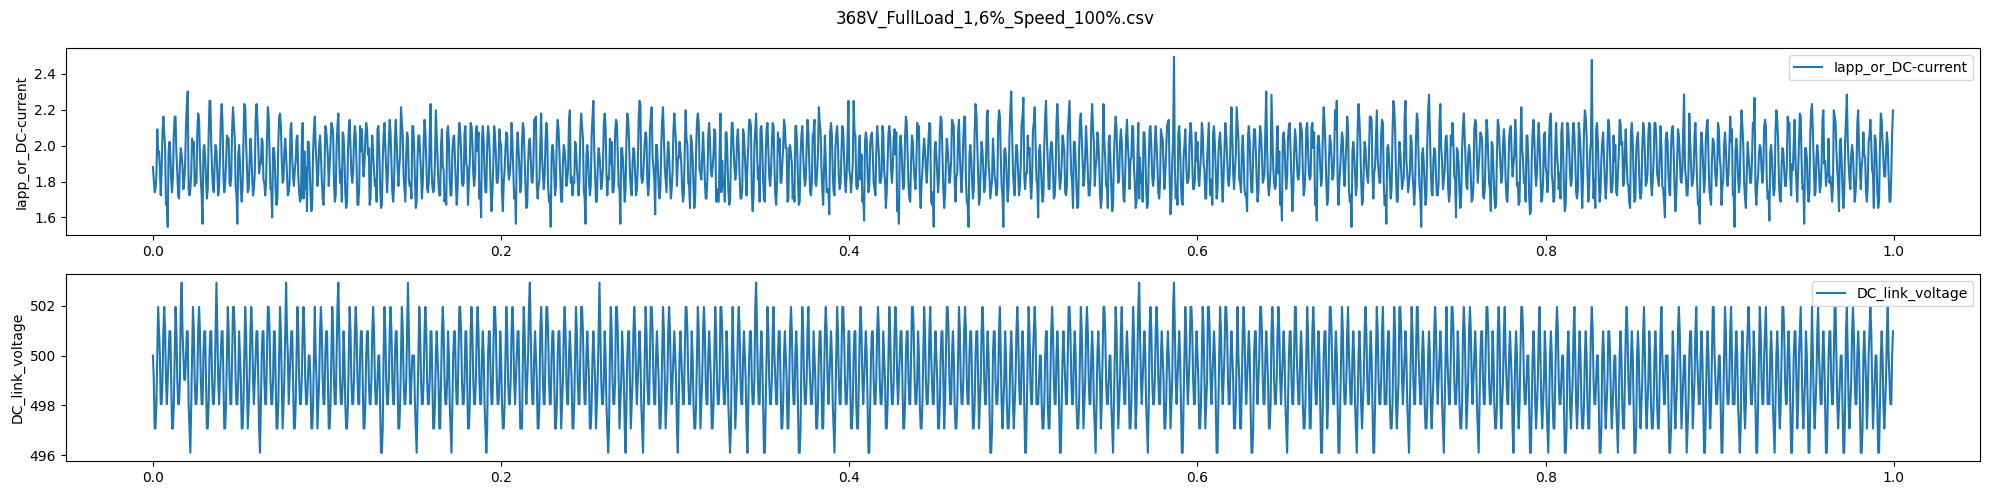

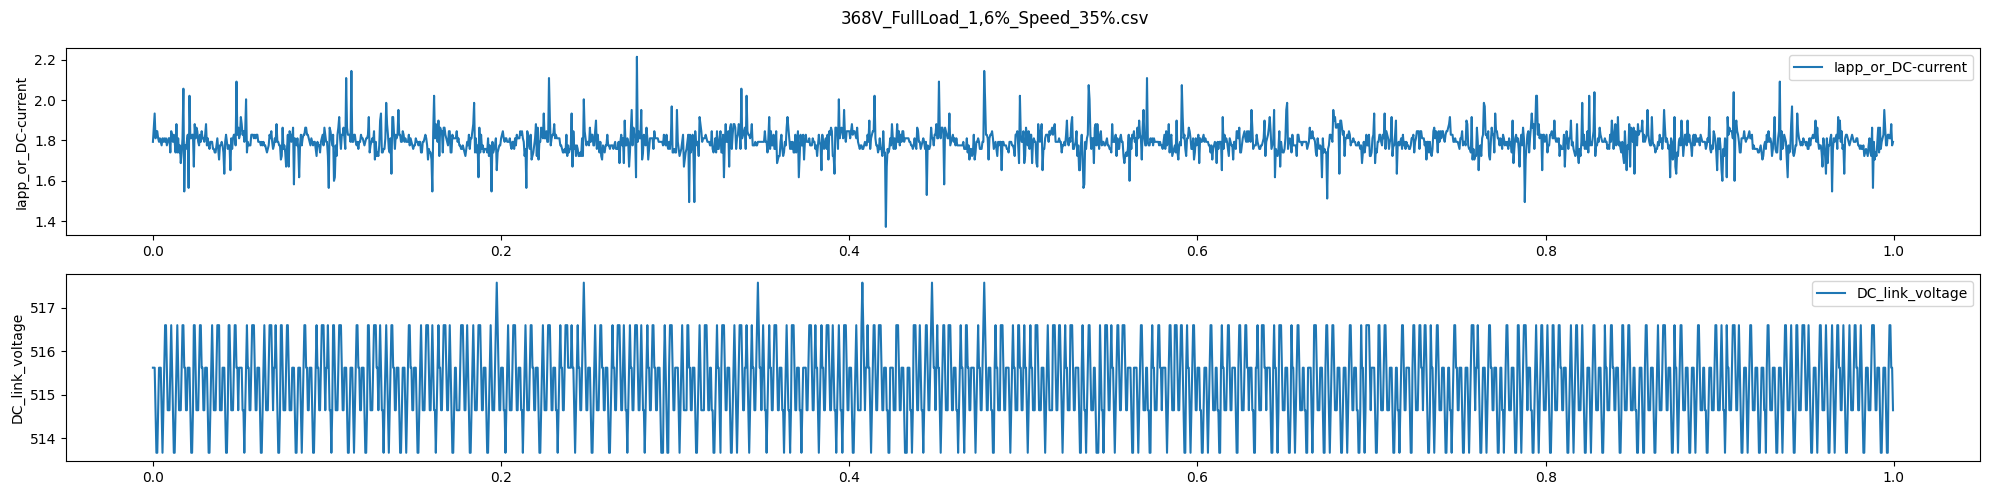

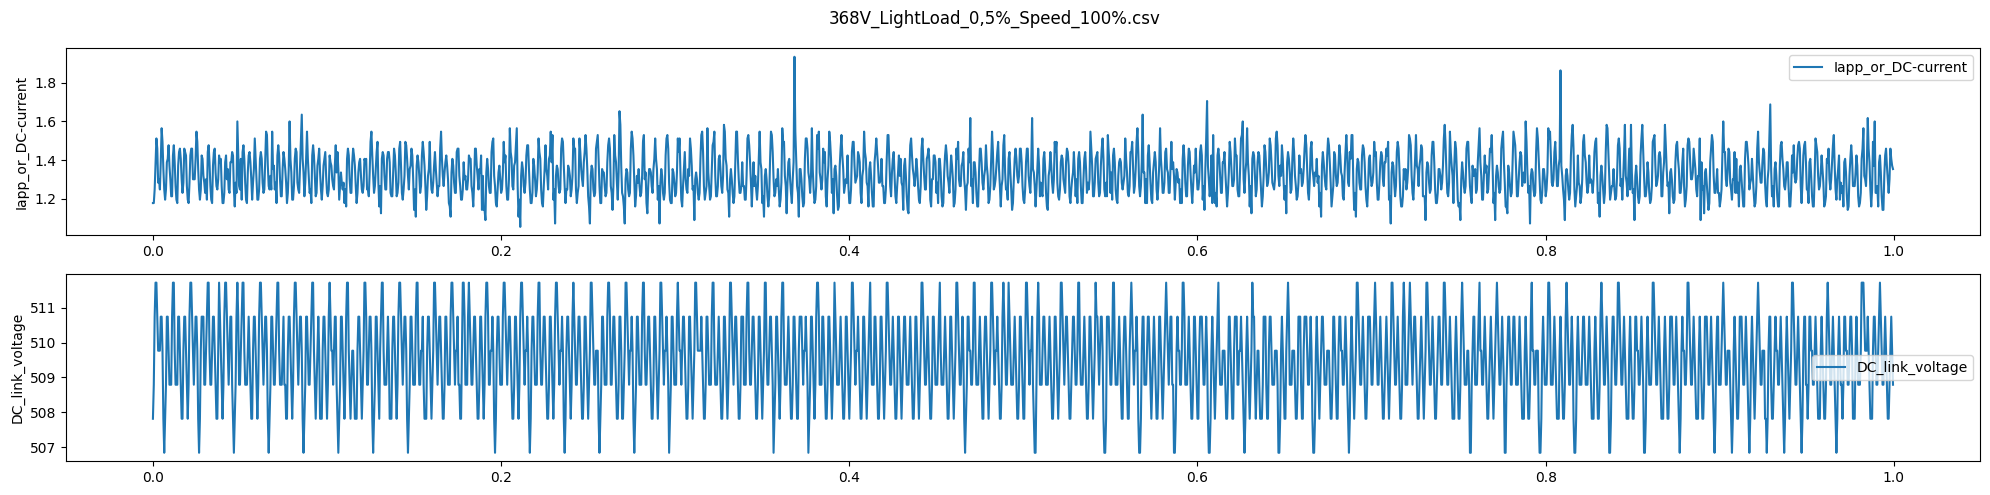

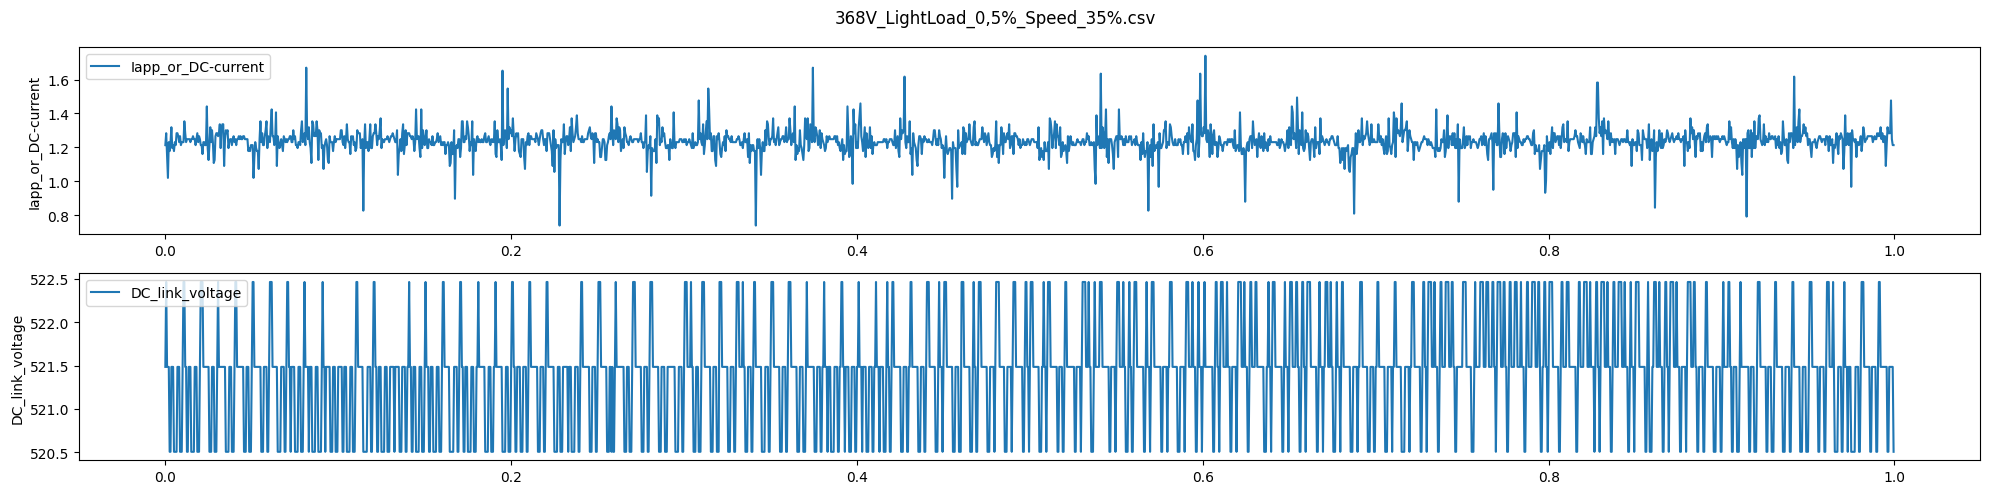

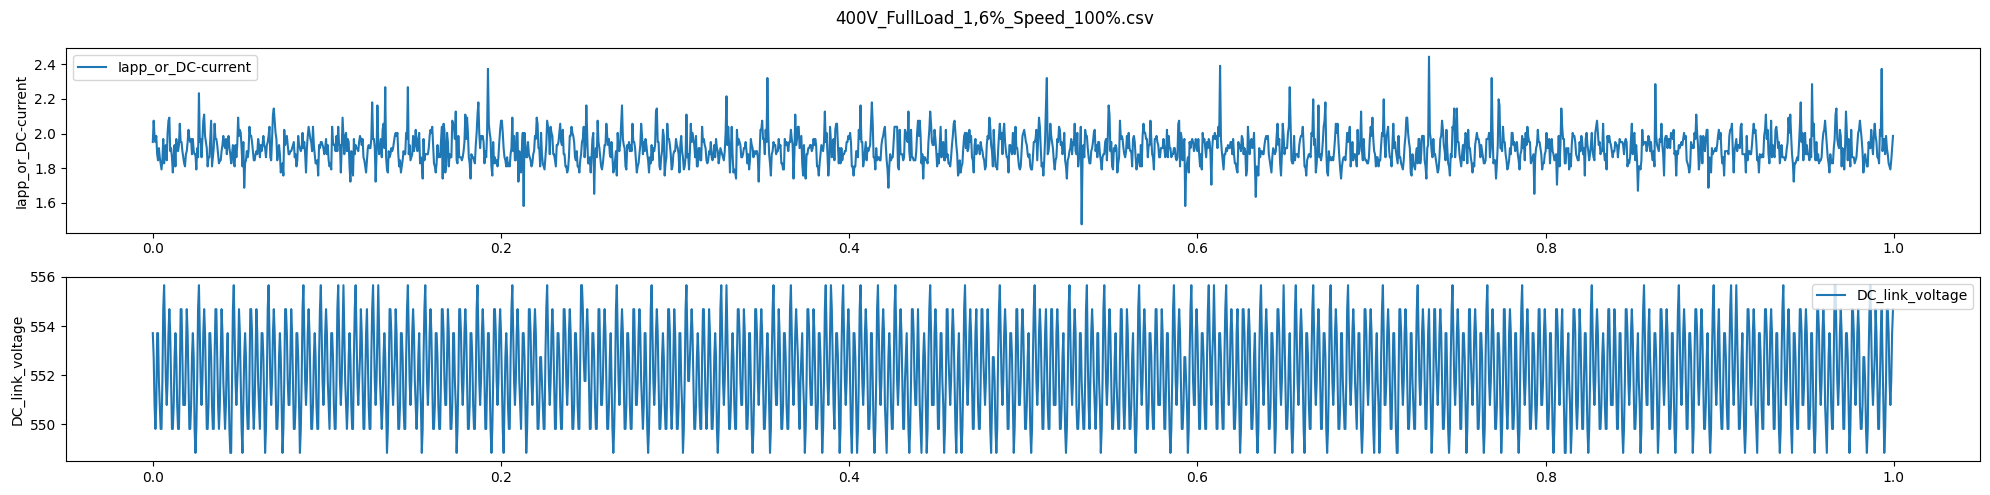

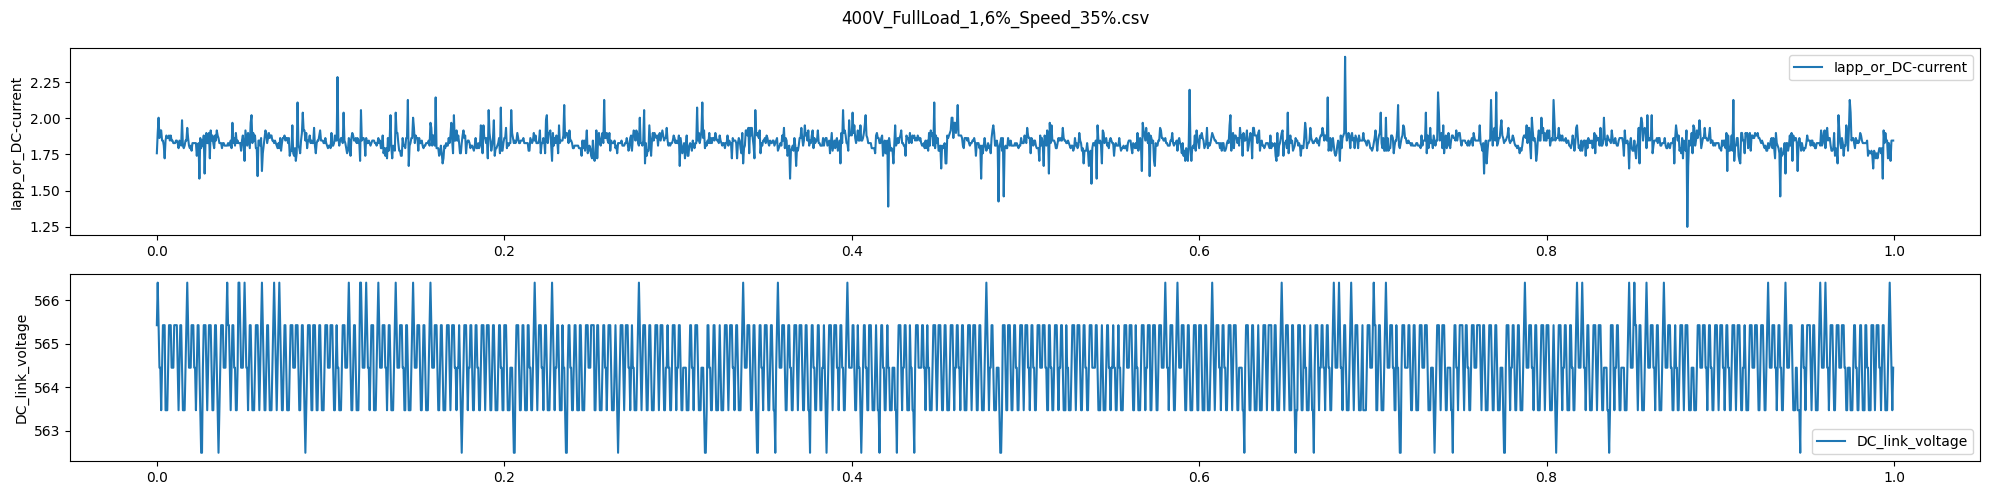

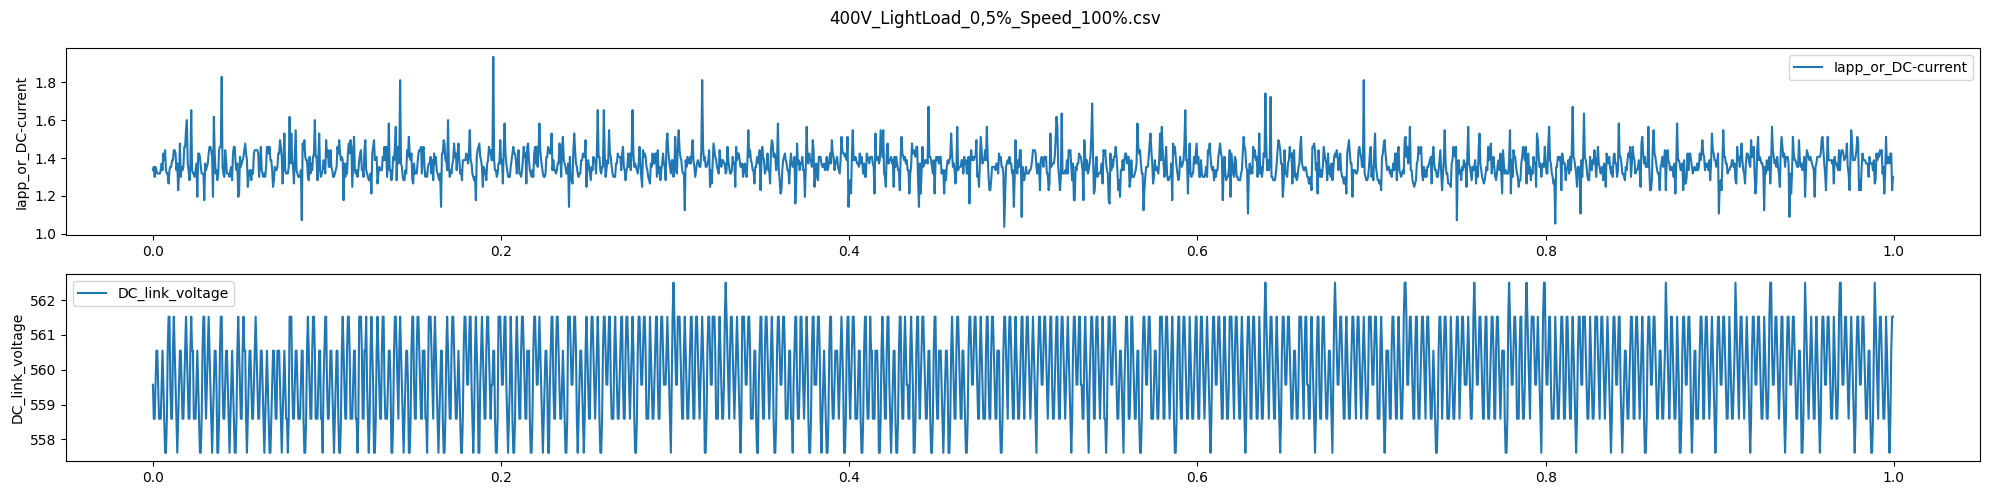

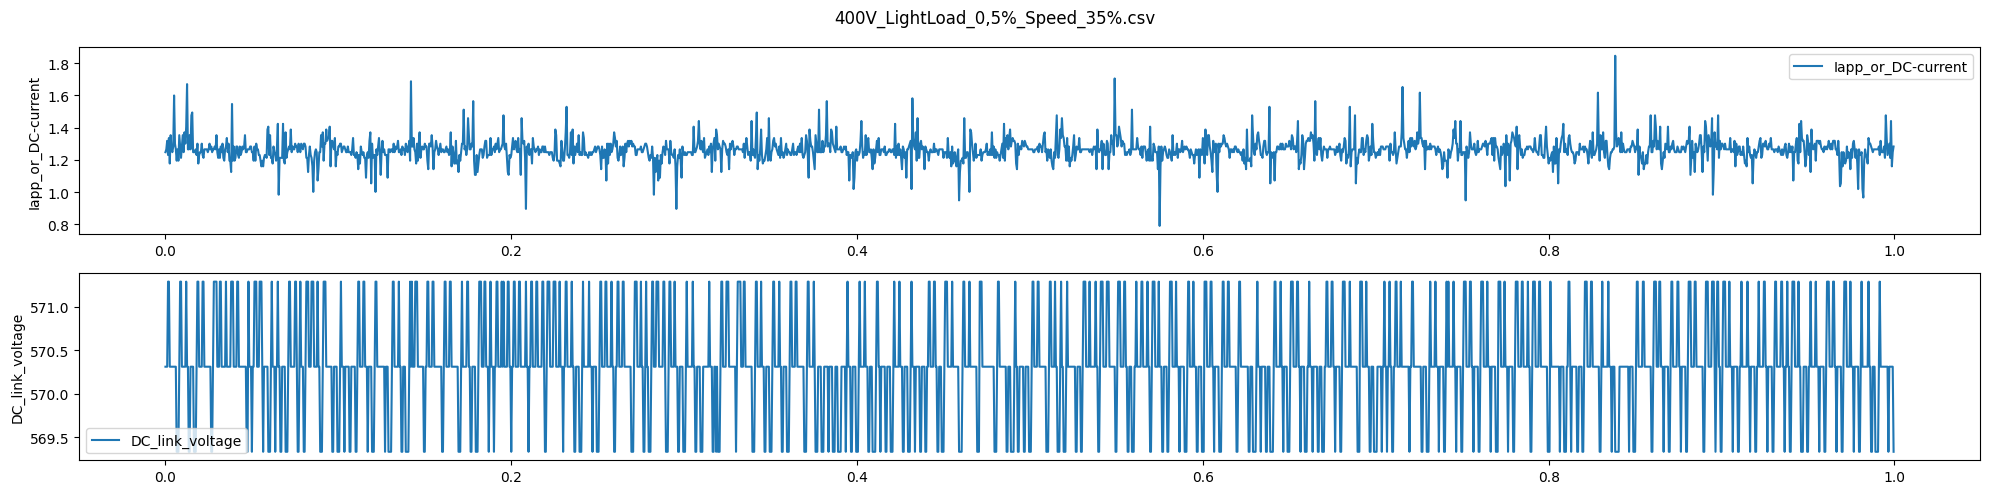

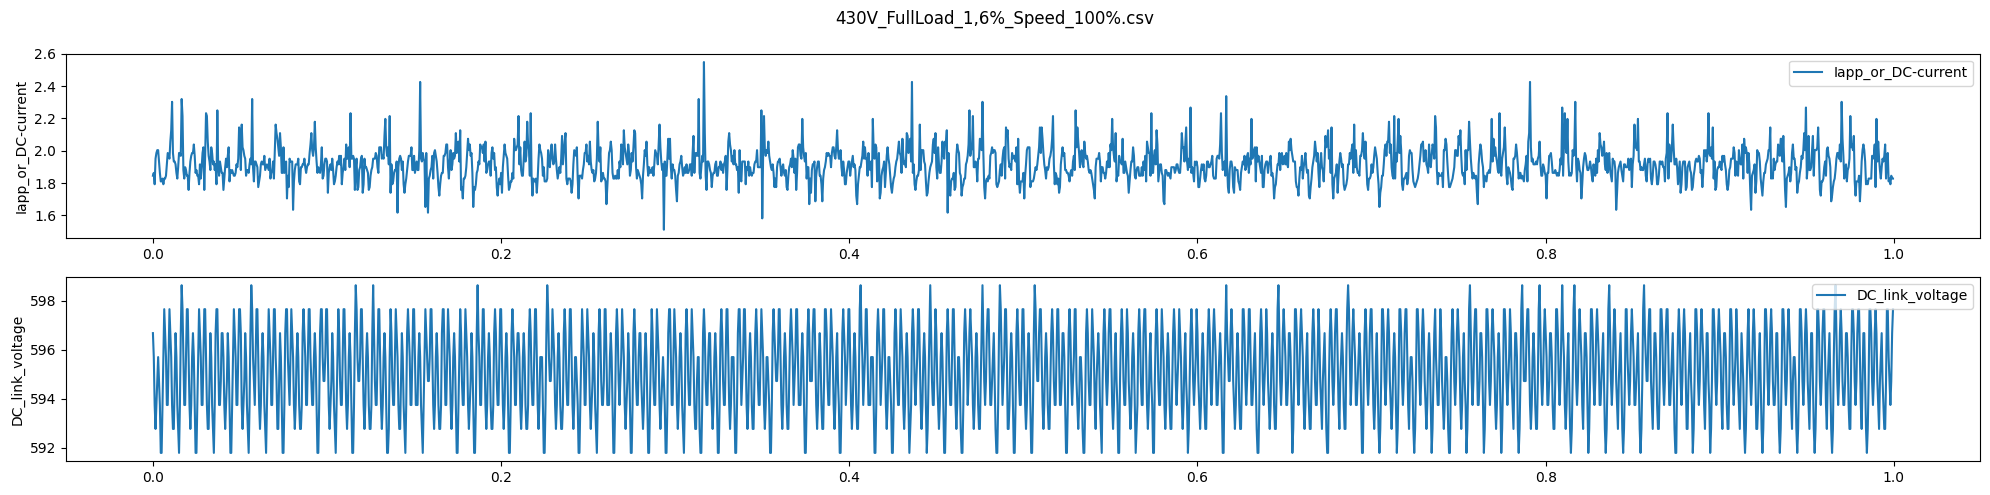

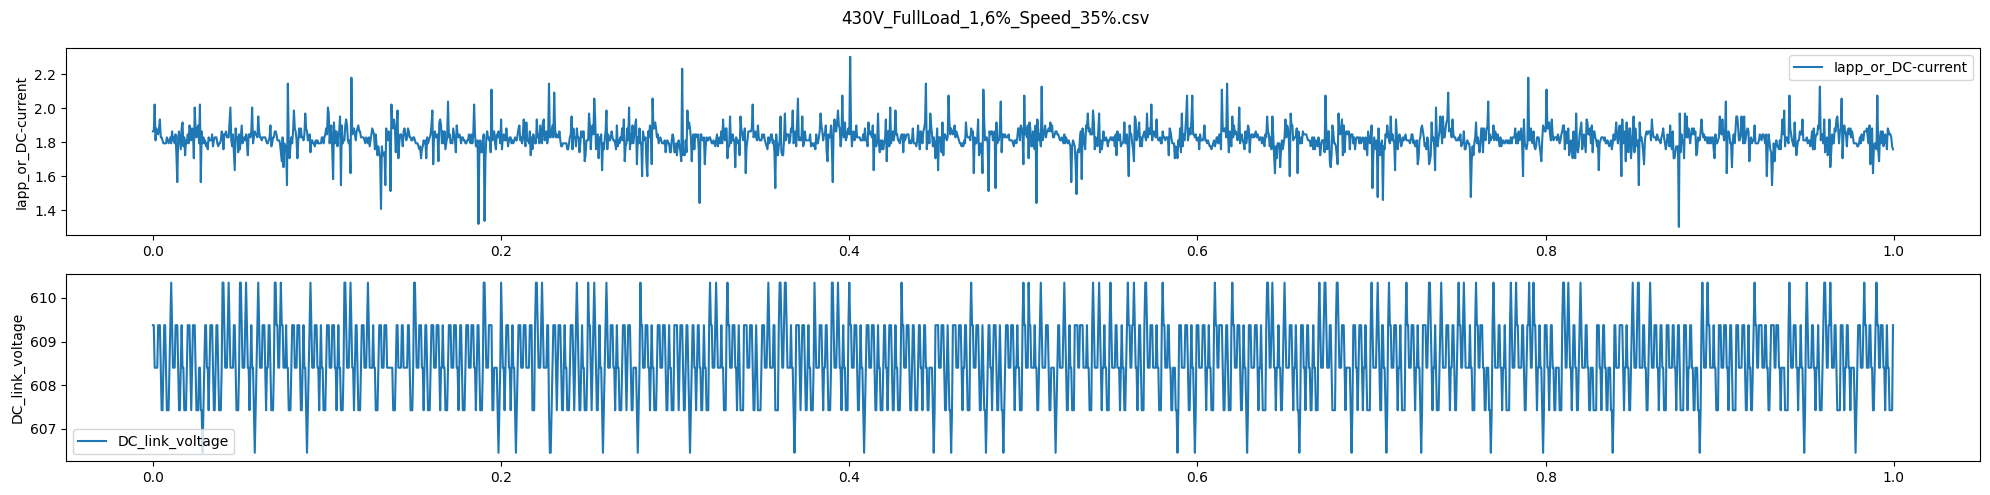

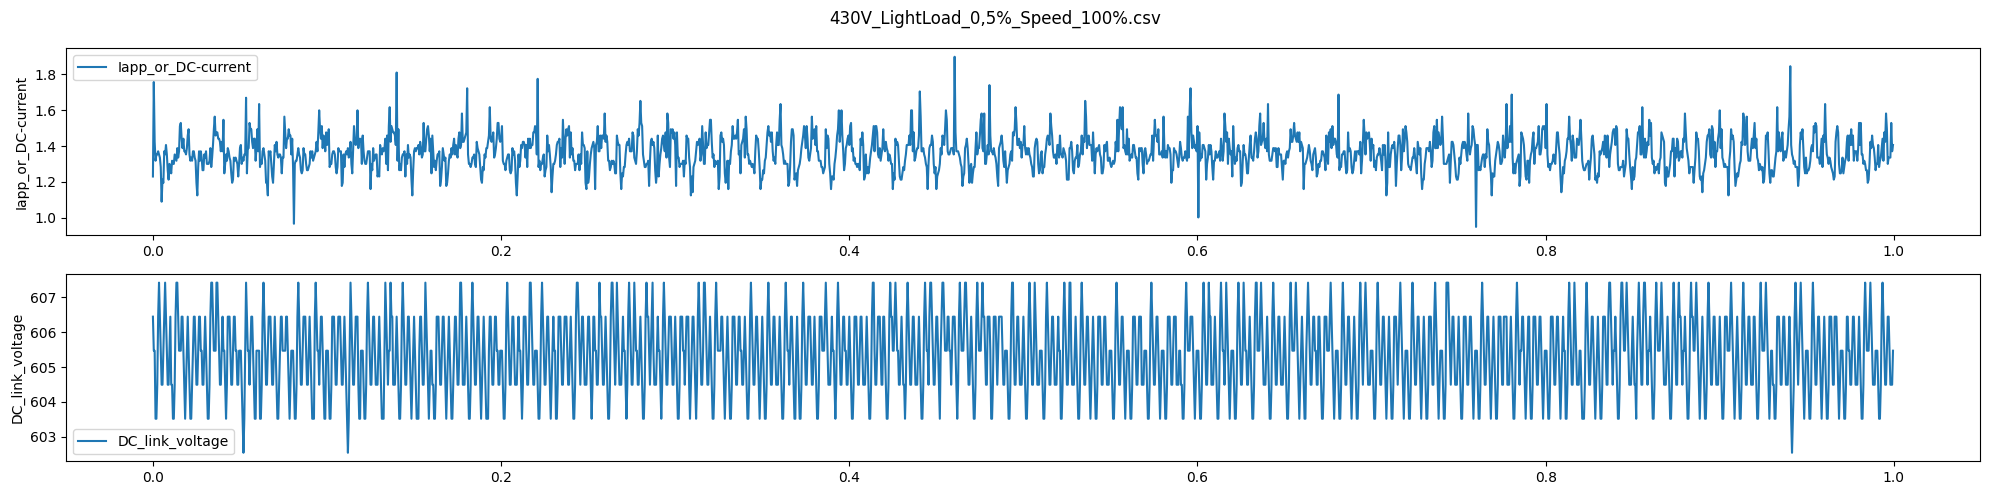

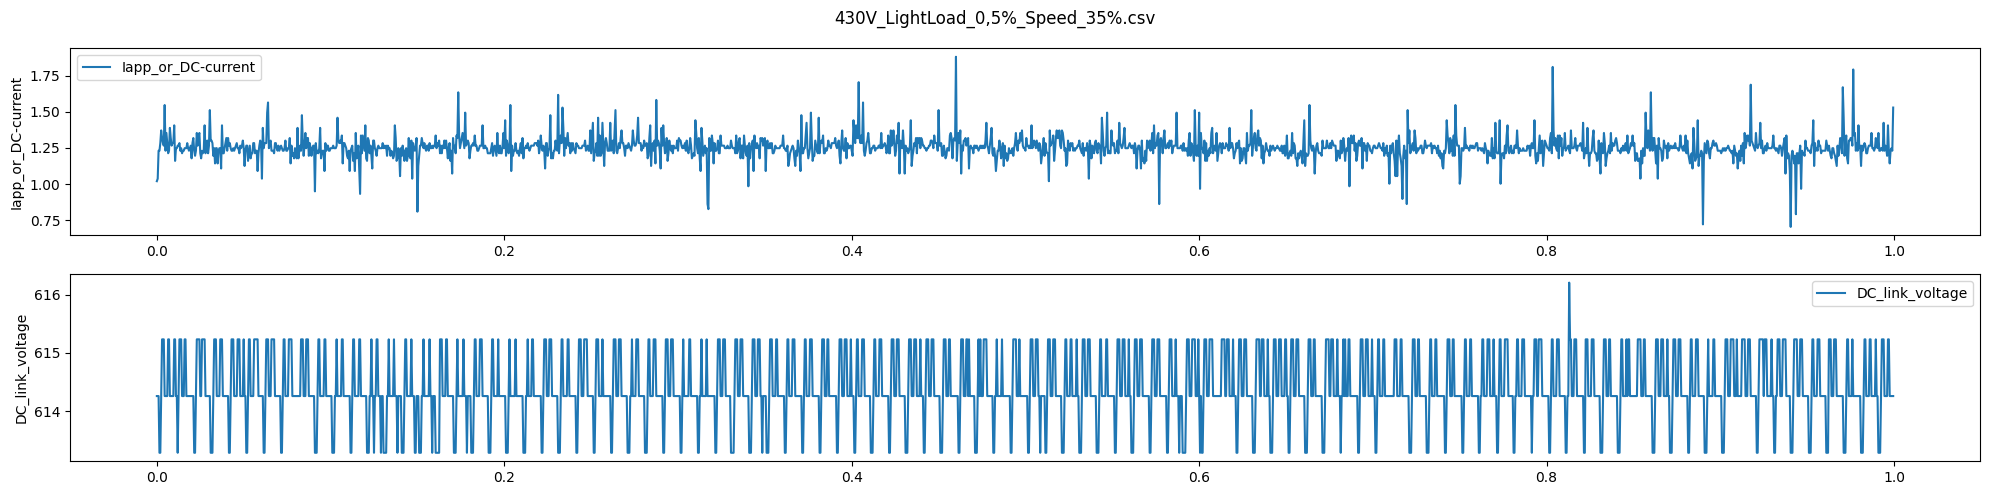

In [23]:
for file_name in files_drei_phasen:
    show_diagram(file_name)

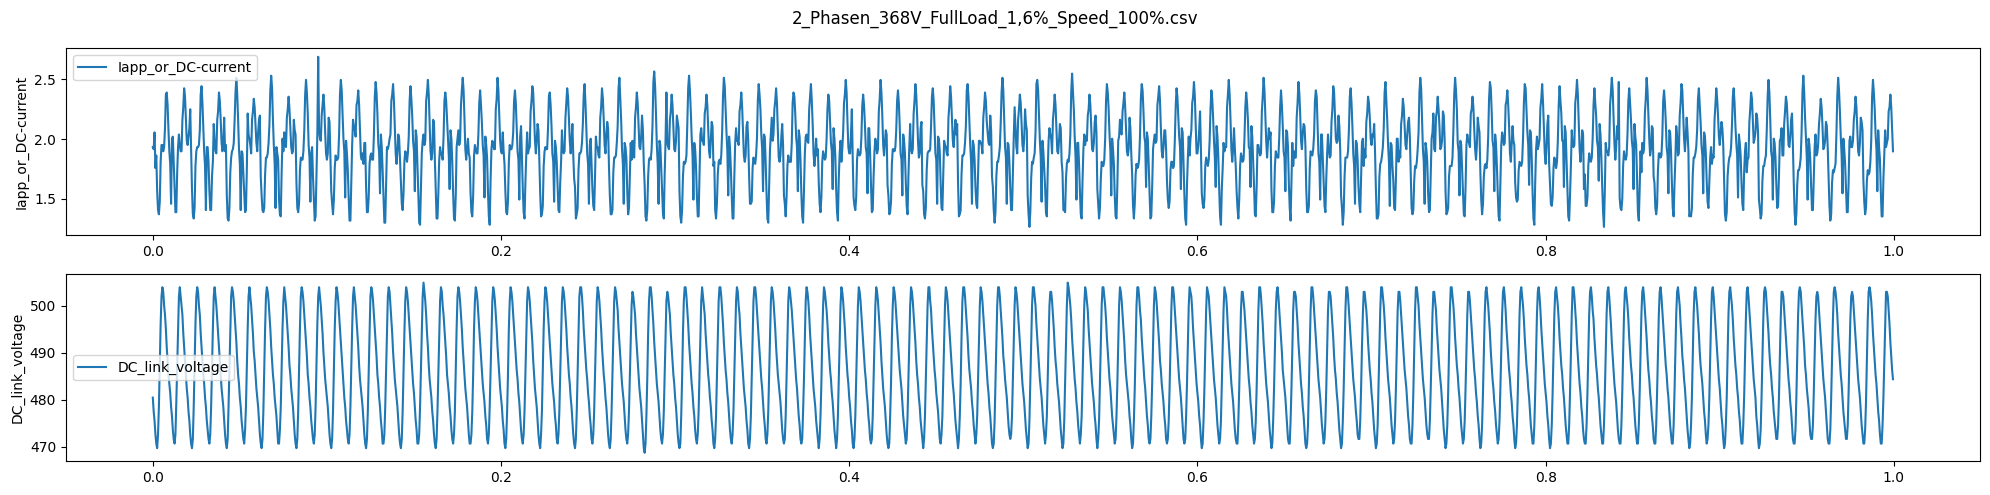

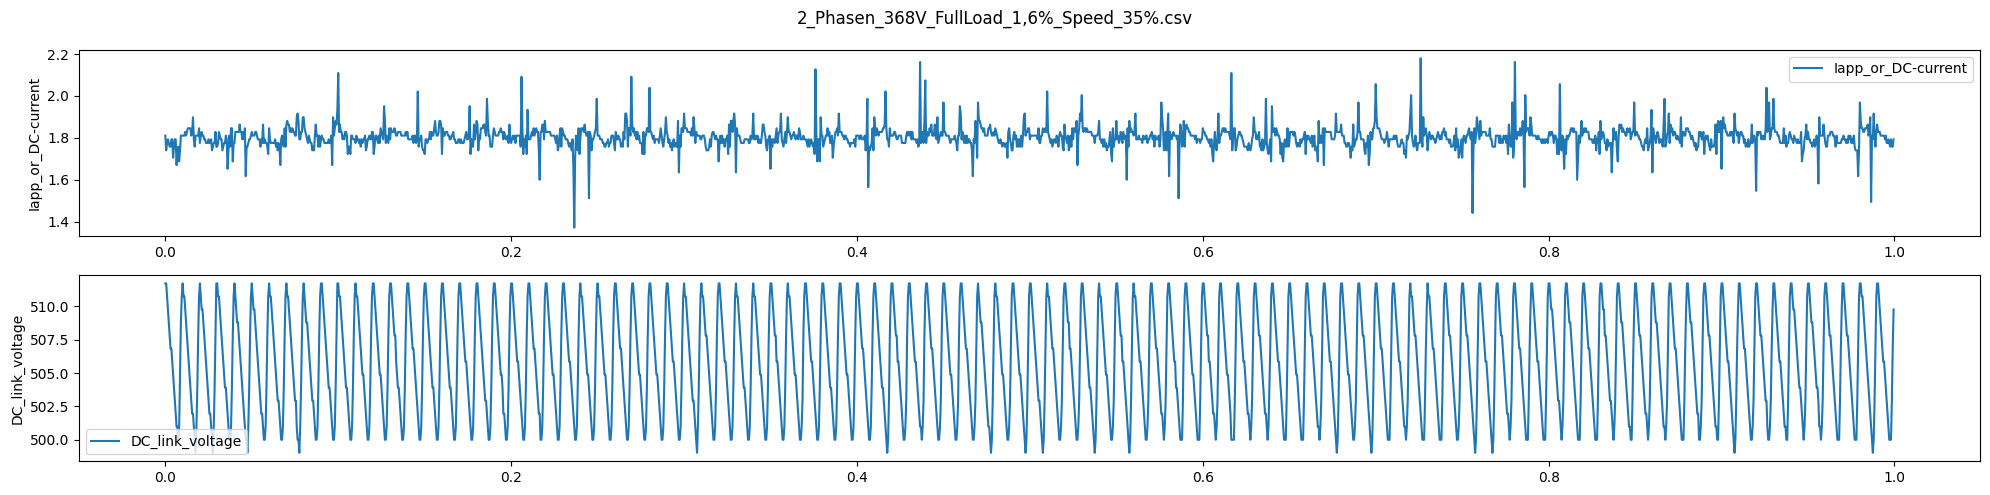

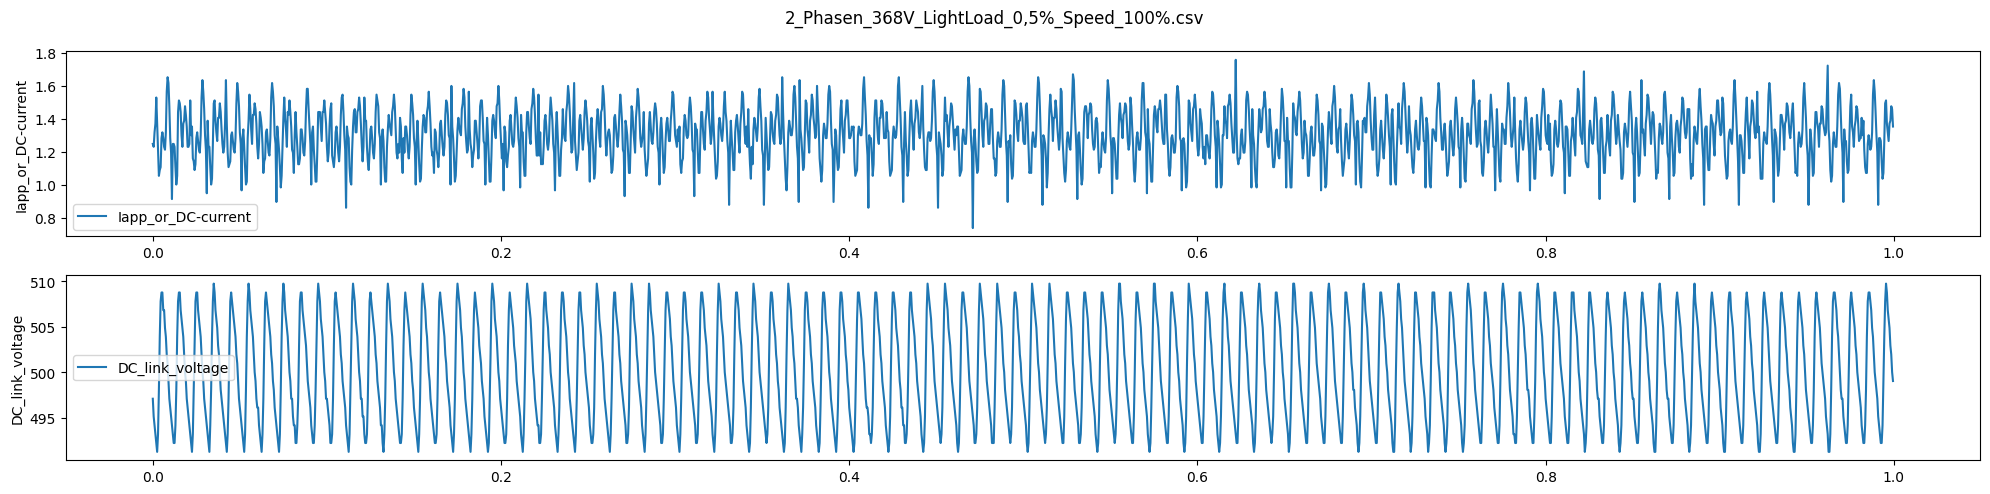

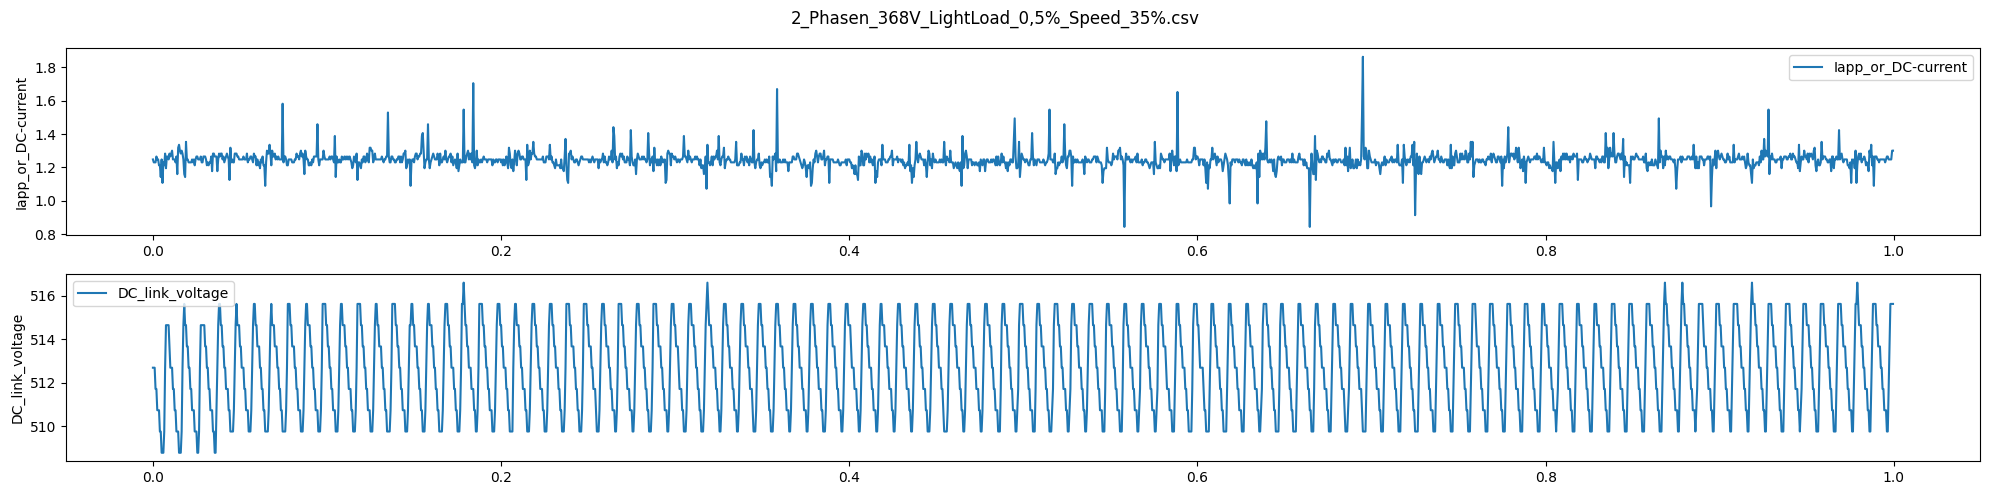

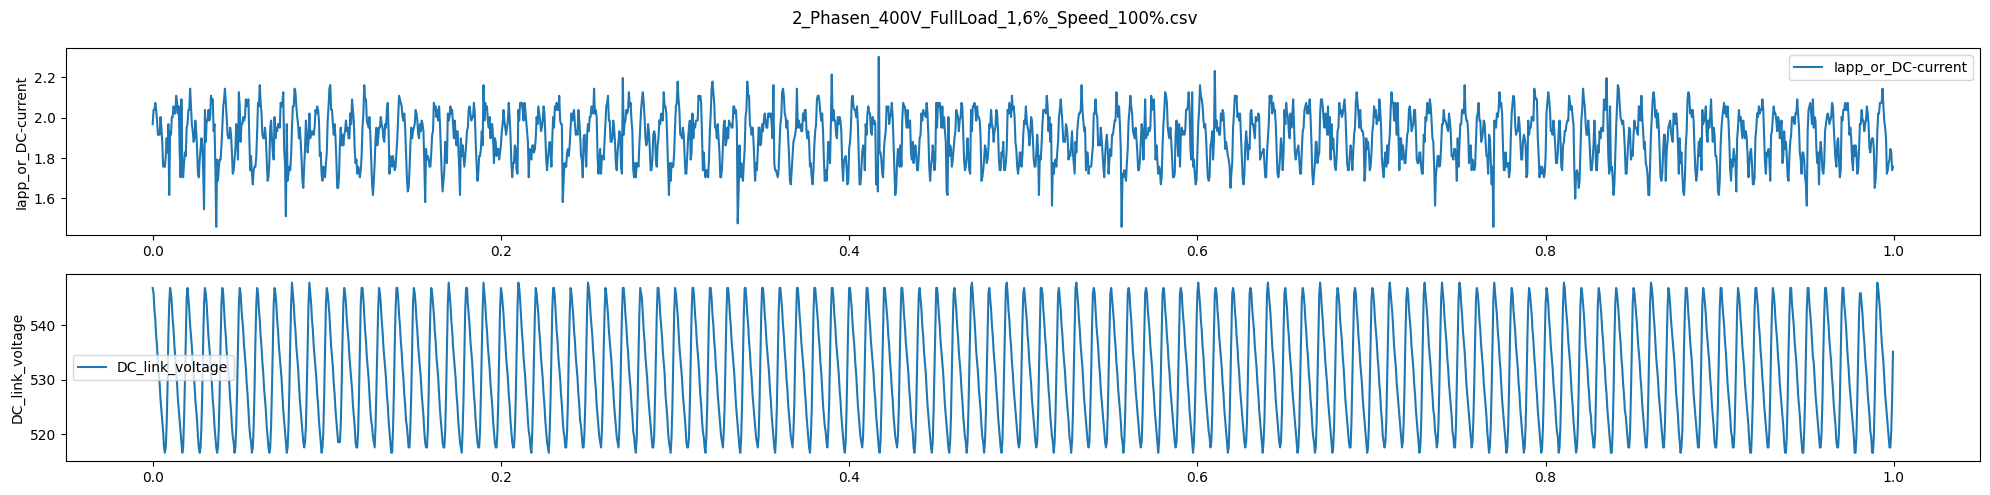

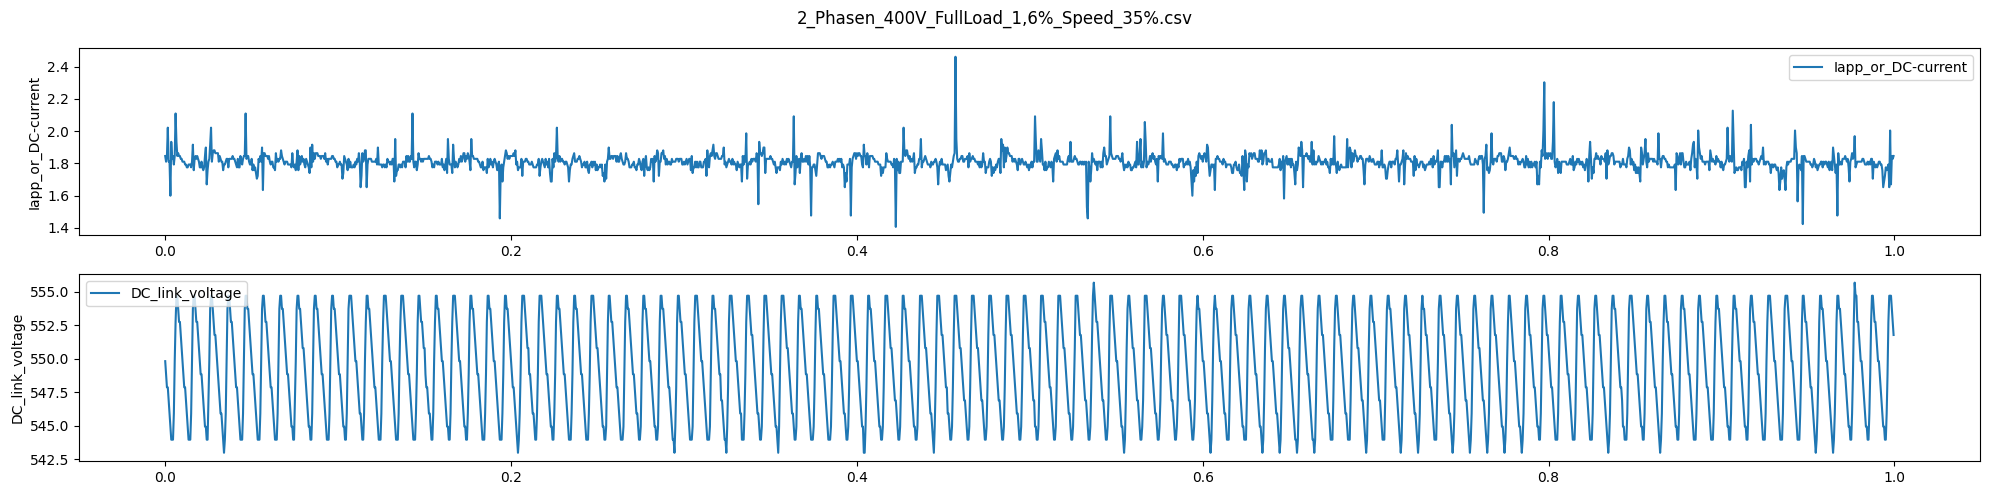

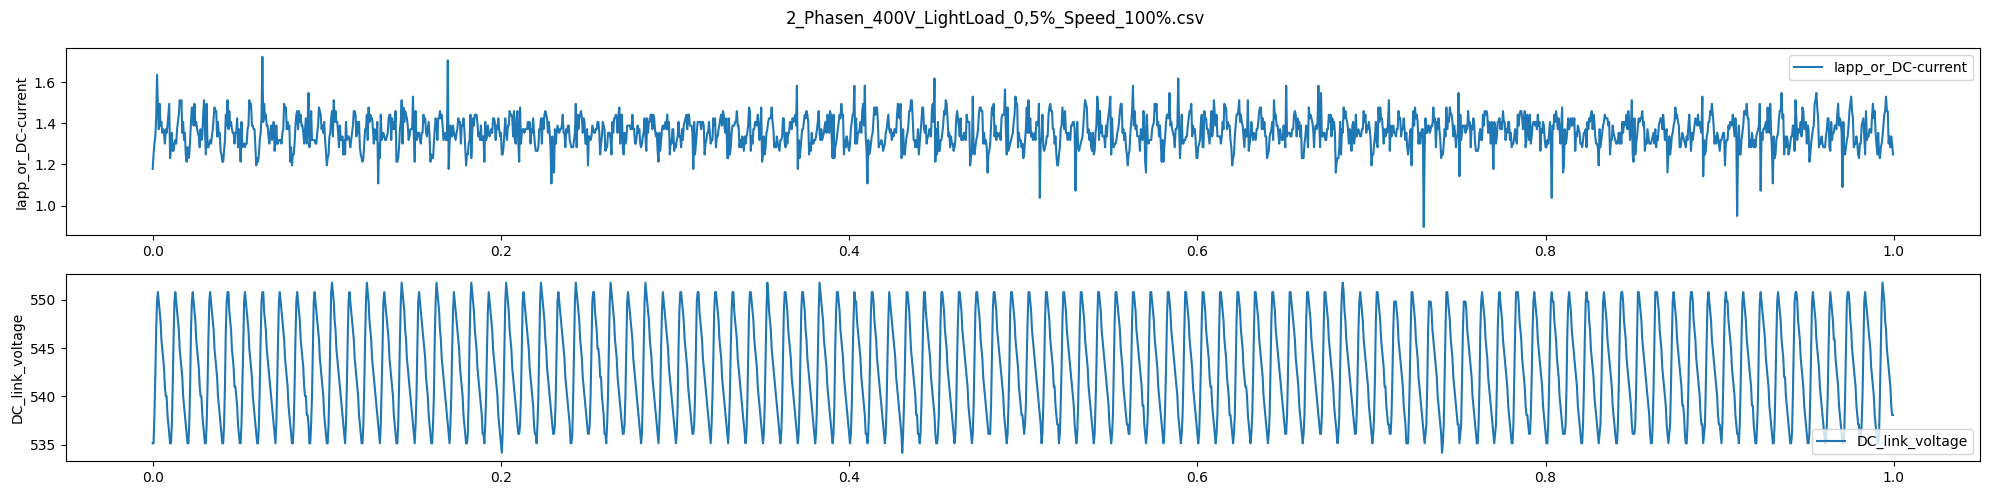

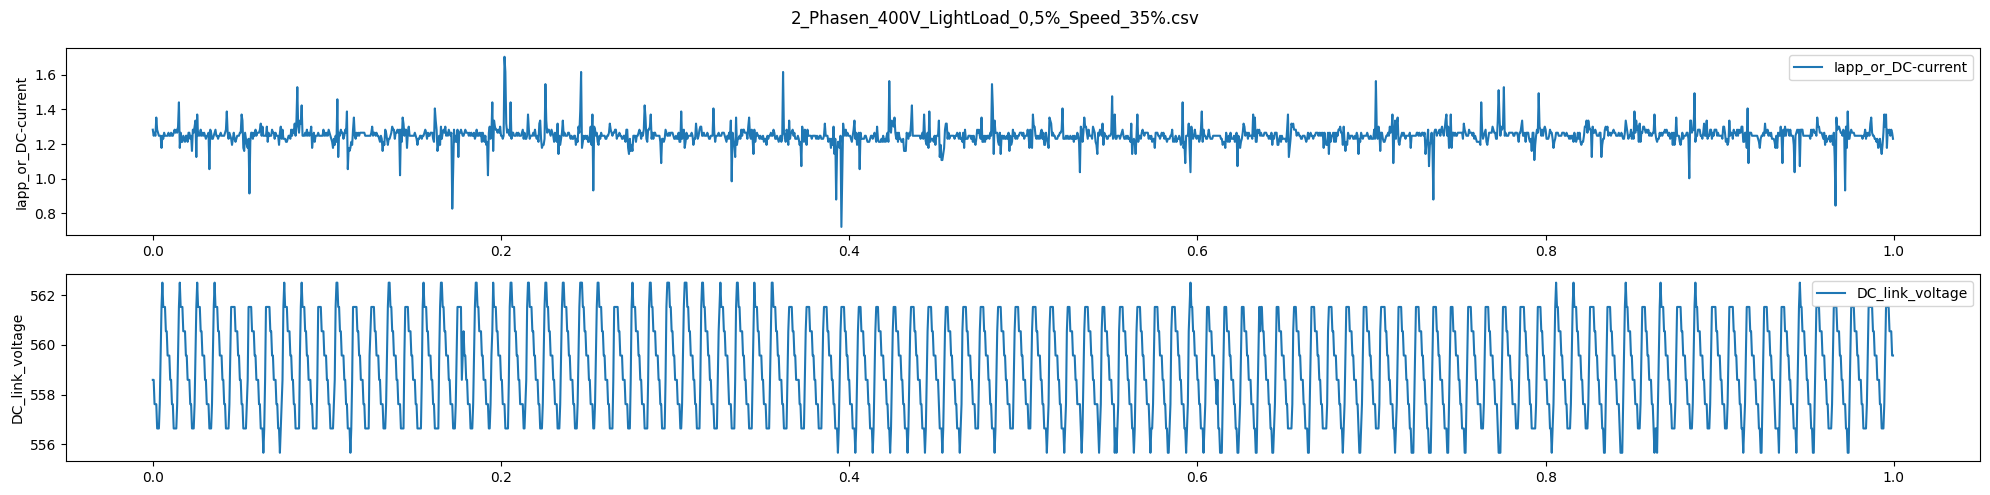

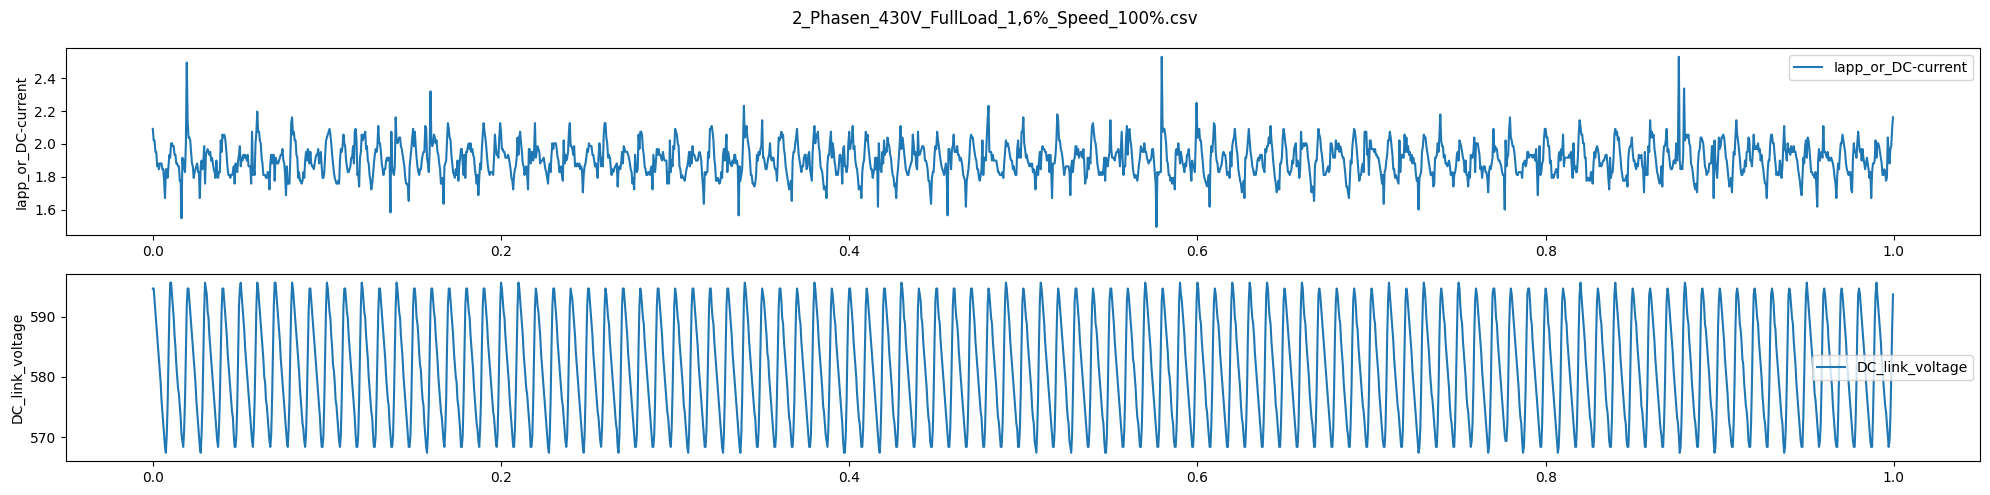

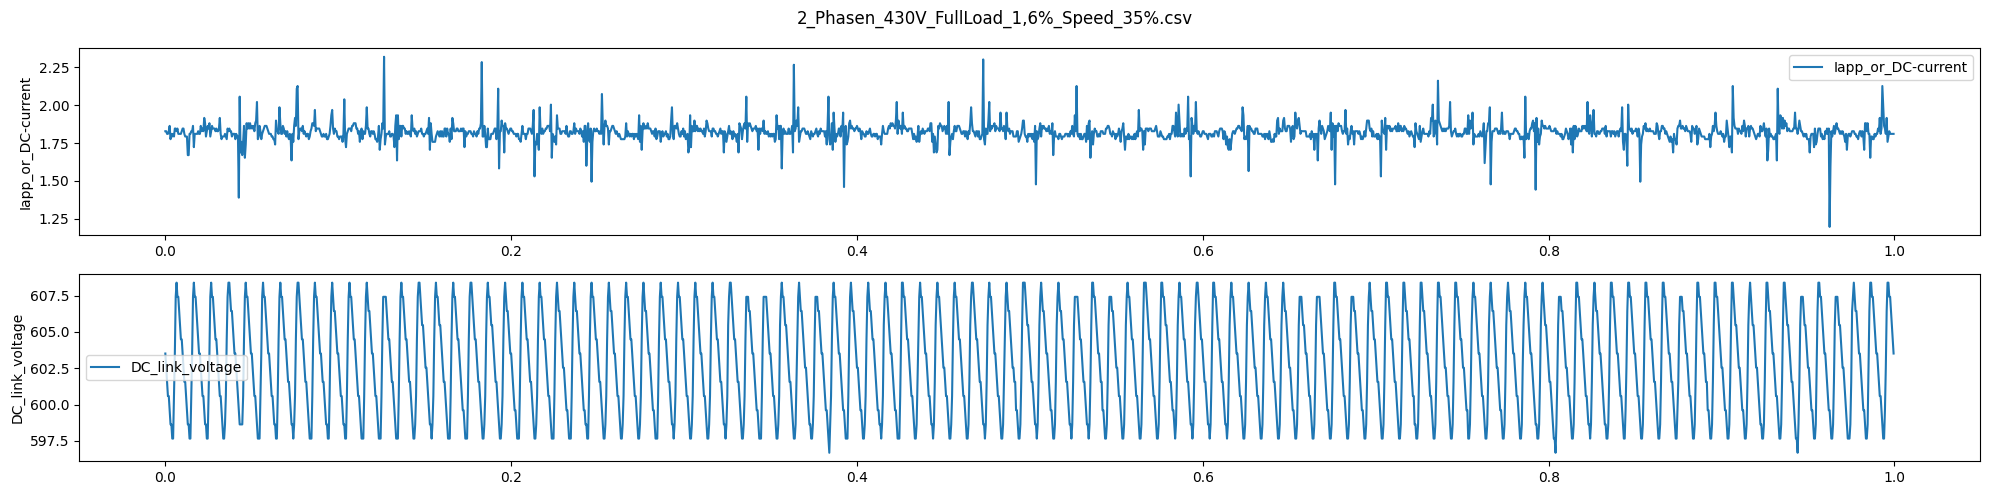

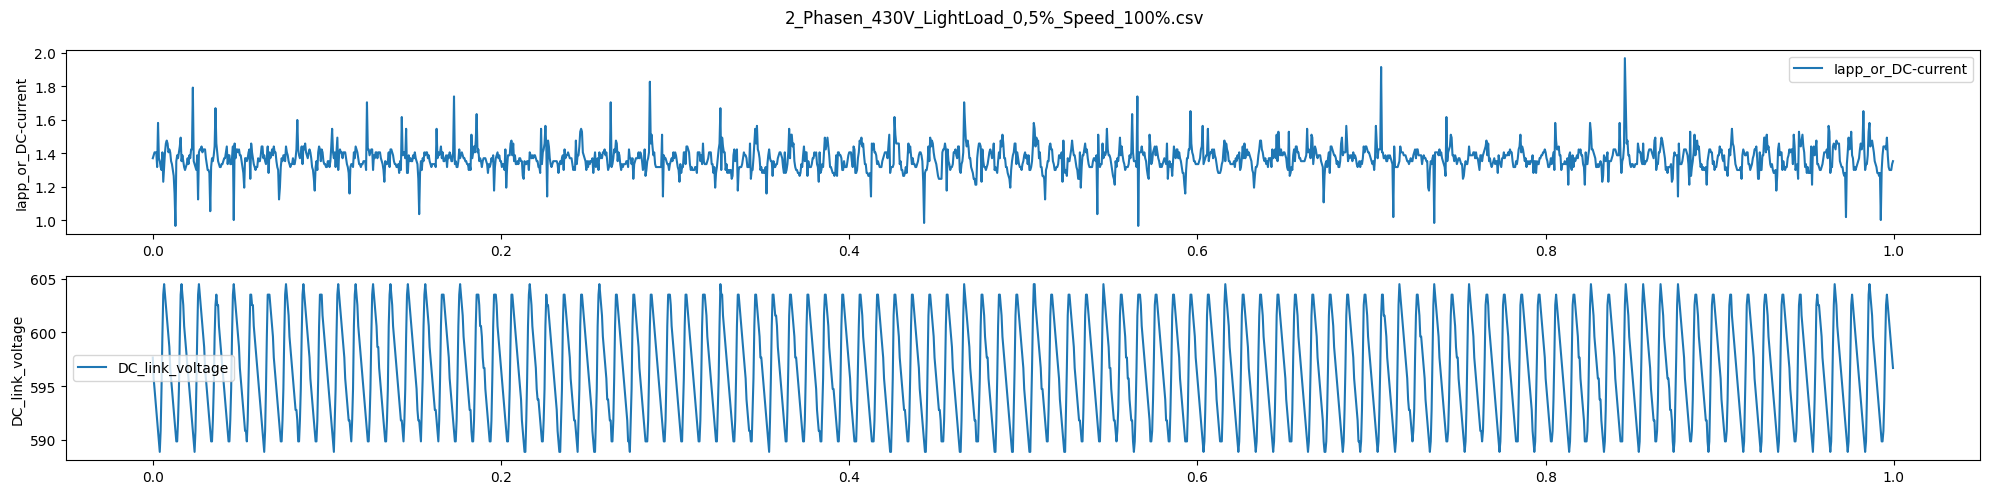

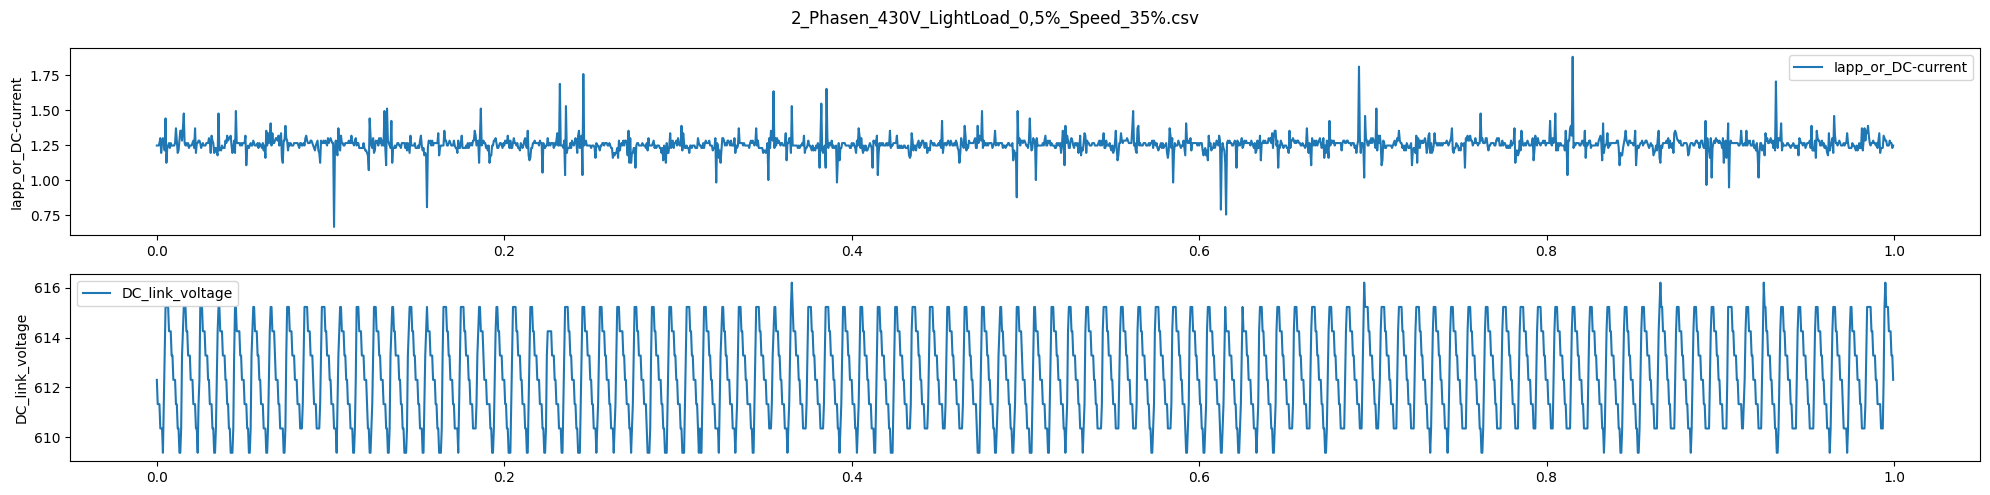

In [24]:
for file_name in files_zwei_phasen:
    show_diagram(file_name)

## First Test

In [11]:
files_drei_phasen_train = files_drei_phasen
files_zwei_phasen_train = files_zwei_phasen

In [8]:
files_drei_phasen_valid = files_drei_phasen[:1]
files_zwei_phasen_valid = files_zwei_phasen[:1]

In [13]:
files_zwei_phasen_train

['2_Phasen_368V_FullLoad_1,6%_Speed_100%.csv',
 '2_Phasen_368V_FullLoad_1,6%_Speed_35%.csv',
 '2_Phasen_368V_LightLoad_0,5%_Speed_100%.csv',
 '2_Phasen_368V_LightLoad_0,5%_Speed_35%.csv',
 '2_Phasen_400V_FullLoad_1,6%_Speed_100%.csv',
 '2_Phasen_400V_FullLoad_1,6%_Speed_35%.csv',
 '2_Phasen_400V_LightLoad_0,5%_Speed_100%.csv',
 '2_Phasen_400V_LightLoad_0,5%_Speed_35%.csv',
 '2_Phasen_430V_FullLoad_1,6%_Speed_100%.csv',
 '2_Phasen_430V_FullLoad_1,6%_Speed_35%.csv',
 '2_Phasen_430V_LightLoad_0,5%_Speed_100%.csv',
 '2_Phasen_430V_LightLoad_0,5%_Speed_35%.csv']

In [39]:
files_drei_phasen_valid

['400V_FullLoad_1,6%_Speed_35%.csv',
 '400V_LightLoad_0,5%_Speed_100%.csv',
 '400V_LightLoad_0,5%_Speed_35%.csv',
 '430V_FullLoad_1,6%_Speed_100%.csv',
 '430V_FullLoad_1,6%_Speed_35%.csv',
 '430V_LightLoad_0,5%_Speed_100%.csv',
 '430V_LightLoad_0,5%_Speed_35%.csv']

In [14]:
data, rocket_parameter = get_data(
    files_drei_phasen_train,
    files_zwei_phasen_train,
    files_drei_phasen_valid,
    files_zwei_phasen_valid,
)

In [17]:
biases = rocket_parameter[2][::8]

In [18]:
biases

array([  2.2296546,  11.718262 ,   0.8022357,  -0.9774496,   3.9054496,
        -0.9765625,  -9.766113 ,  -2.9301758,  -5.8598633,  -2.9301758,
       -55.23152  ], dtype=float32)

In [15]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = data

In [16]:
X_train

0         1         2         3         4         5         6    
0     510.7422  509.7656  509.7656  510.7422  512.6953  514.6484  515.6249  \
1      508.789   508.789  509.7656  509.7656   508.789  507.8125  507.8125   
2     610.3515  610.3515  612.3046  614.2578  615.2343  616.2109  615.2343   
3     559.5703  558.5937  558.5937  557.6171  557.6171  556.6406  556.6406   
4     603.5156  603.5156  605.4687  607.4218  607.4218  606.4453  605.4687   
...        ...       ...       ...       ...       ...       ...       ...   
8663  472.6562  471.6797  473.6328  478.5156  487.3047  496.0937  501.9531   
8664  609.3749  608.3984  608.3984  608.3984  609.3749  610.3515  609.3749   
8665  498.0468  499.0234  500.9765  501.9531  500.9765  499.0234  498.0468   
8666  505.8593  504.8828  502.9297  501.9531     500.0  499.0234  497.0703   
8667  509.7656  511.7187  511.7187  509.7656   508.789   508.789   508.789   

            7         8         9   ...        40        41        42   
0     515.6249  515.6249  514.6484  ...  509.7656  509.7656  509.7656  \
1     507.8125   508.789  509.7656  ...   508.789   508.789  509.7656   
2     615.2343  614.2578  614.2578  ...  610.3515  610.3515  612.3046   
3     556.6406   555.664  557.6171  ...  559.5703  558.5937  558.5937   
4     605.4687  605.4687  606.4453  ...  603.5156  603.5156  605.4687   
...        ...       ...       ...  ...       ...       ...       ...   
8663  503.9062  502.9297     500.0  ...  472.6562  471.6797  472.6562   
8664  608.3984  608.3984  608.3984  ...  609.3749  608.3984  608.3984   
8665  498.0468     500.0  500.9765  ...  498.0468  499.0234  500.9765   
8666  496.0937  495.1172  494.1406  ...  505.8593  504.8828  502.9297   
8667  511.7187  512.6953  512.6953  ...  509.7656  511.7187  510.7422   

            43        44        45        46        47        48        49  
0     510.7422  512.6953  514.6484  515.6249  515.6249  515.6249  514.6484  
1     509.7656   508.789  507.8125  507.8125  507.8125  509.7656  510.7422  
2     614.2578  615.2343  616.2109  615.2343  615.2343  615.2343  614.2578  
3     557.6171  557.6171  557.6171  556.6406  556.6406  556.6406  557.6171  
4     606.4453  607.4218  606.4453  605.4687  604.4921  605.4687  606.4453  
...        ...       ...       ...       ...       ...       ...       ...  
8663  478.5156  486.3281  495.1172  501.9531  503.9062  502.9297     500.0  
8664  608.3984  609.3749  610.3515  609.3749  608.3984  608.3984  607.4218  
8665  501.9531  500.9765  499.0234  498.0468  498.0468     500.0  500.9765  
8666  501.9531     500.0  499.0234  498.0468  497.0703  495.1172  494.1406  
8667  509.7656   508.789  507.8125   508.789  511.7187  512.6953  511.7187  

[8668 rows x 50 columns]

In [25]:
log_reg = apply_rocket(data, biases)

c:\Users\je009447\AppData\Local\miniconda3\envs\test_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.1449258  0.24325738 0.12326112 0.12848863 0.2021018  0.07310376
 0.23516719 0.19519691 0.10768995 0.22614168 0.00310855]
[  2.2296546  11.718262    0.8022357  -0.9774496   3.9054496  -0.9765625
  -9.766113   -2.9301758  -5.8598633  -2.9301758 -55.23152  ]
[[ 2.60765275  0.77121237  2.21937962 -1.04119292 -0.71503676  1.12618569
   0.04239991 -0.19107477  1.12125466 -3.05517863 -0.06443683]]
[0.00076851]
Time needed for 3080 prediction: 15.65922212600708
The test accuracy is 1.0
The validation accuracy is 1.0


# Testen von CNN


In [25]:
dataset, data = pytorch_prep(
    files_drei_phasen,
    files_zwei_phasen,
    "400V_FullLoad_1,6%_Speed_100%.csv",
    "2_Phasen_400V_FullLoad_1,6%_Speed_100%.csv",
)

In [36]:
X_test, X_valid, Y_test, Y_valid = data
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
X_valid = torch.tensor(X_valid, dtype=torch.float32).unsqueeze(1)
X_test.shape

C:\Users\je009447\AppData\Local\Temp\ipykernel_20920\3113167553.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
C:\Users\je009447\AppData\Local\Temp\ipykernel_20920\3113167553.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid = torch.tensor(X_valid, dtype=torch.float32).unsqueeze(1)


torch.Size([948, 1, 100])

In [54]:

batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define model parameters
in_channels = 1  # Assuming input data has one channel
out_channels = 30  # Number of kernels
kernel_size = 9  # Length of the kernel

# Create an instance of the SimpleCNN model
model = SimpleCNN(in_channels, out_channels, kernel_size)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs.unsqueeze(1))  # Add channel dimension
        
        # Compute the loss
        loss = criterion(outputs.squeeze(), targets)  # Squeeze to match shape
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    
y_pred_test = model(X_test)
y_pred_valid = model(X_valid)


acc_test = accuracy_score(torch.round(y_pred_test).detach().numpy().astype(int), Y_test)
acc_valid = accuracy_score(torch.round(y_pred_valid).detach().numpy().astype(int), Y_valid)
print(f"The test accuracy is {acc_test}")
print(f"The validation accuracy is {acc_valid}")

Epoch [1/1000], Loss: 56.25
Epoch [2/1000], Loss: 68.75
Epoch [3/1000], Loss: 31.25
Epoch [4/1000], Loss: 56.25
Epoch [5/1000], Loss: 62.5
Epoch [6/1000], Loss: 50.0
Epoch [7/1000], Loss: 50.0
Epoch [8/1000], Loss: 50.0
Epoch [9/1000], Loss: 50.0
Epoch [10/1000], Loss: 62.5
Epoch [11/1000], Loss: 43.75
Epoch [12/1000], Loss: 56.25
Epoch [13/1000], Loss: 50.0
Epoch [14/1000], Loss: 62.5
Epoch [15/1000], Loss: 68.75
Epoch [16/1000], Loss: 50.0
Epoch [17/1000], Loss: 37.5
Epoch [18/1000], Loss: 62.5
Epoch [19/1000], Loss: 75.0
Epoch [20/1000], Loss: 43.75
Epoch [21/1000], Loss: 43.75
Epoch [22/1000], Loss: 43.75
Epoch [23/1000], Loss: 56.25
Epoch [24/1000], Loss: 62.5
Epoch [25/1000], Loss: 43.75
Epoch [26/1000], Loss: 43.75
Epoch [27/1000], Loss: 56.25
Epoch [28/1000], Loss: 75.0
Epoch [29/1000], Loss: 43.75
Epoch [30/1000], Loss: 56.25
Epoch [31/1000], Loss: 68.75
Epoch [32/1000], Loss: 56.25
Epoch [33/1000], Loss: 56.25
Epoch [34/1000], Loss: 50.0
Epoch [35/1000], Loss: 56.25
Epoch [36

In [47]:
y_pred_test

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

# Testen neuer Daten
Das Model muss zunächst trainiert werden, dazu führen Sie die Funktion "test_accuracy" in der vorherigen Zelle aus.  
Den csv file den Sie testen möchten, muss in einem Ordner "Raw_Data" liegen, welcher wiederum im gleichen Ordner wie dieses Notebook liegen muss.  
Der name der Datei sollte "test" enhalten, damit das Training die test Daten ignoriert.  
Testen Sie nur ein csv file auf einmal, oder nutzen Sie einen for loop.  


In [42]:
for file_name in files_drei_phasen_valid:
    test_neue_daten_eigen(
        file_name,
        rocket_parameter,
        log_reg,
    )

0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [43]:
for file_name in files_zwei_phasen_valid:
    test_neue_daten_eigen(
        file_name,
        rocket_parameter,
        log_reg,
    )

1.0
1.0
1.0
1.0
1.0
1.0


In [36]:
test_neue_daten_eigen(
    "2_Phasen_430V_FullLoad_1,6%_Speed_100%.csv",
    rocket_parameter,
    log_reg,
)

1.0


In [26]:
test_neue_daten_eigen(
    "2_Phasen_430V_LightLoad_0,5%_Speed_35%.csv",
    rocket_parameter,
    log_reg,
)

0.0

In [27]:
test_neue_daten_eigen(
    "400V_LightLoad_0,5%_Speed_35%test.csv",
    rocket_parameter,
    log_reg,
)

0.0

# Formel für Logistic regression:
Besteht aus zwei Schritten:  
1. Berechnung von z  
    z = sum(weights*features) + bias  
    Oder vielleicht verständlicher:  
    z = b + w1*x1 + w2*x2 ... wn*xn  
    with b als bias, w als weights und x als features  

2. Anwenden der Sigmoid funktion  
    Anschließend muss die Sigmoid funktion genutzt werden, um das Ergebnis zwischen 0 und 1 zu mappen:  
    y = 1/(1+e^-z)  
    https://de.wikipedia.org/wiki/Sigmoidfunktion  
​

# Formel für Standart Scaler  
Skaliert die features:  
y = x/std(x)  

# MiniRocket:

In [118]:
rocket_transform.parameters

(array([1]),
 array([1]),
 array([ 2.93017030e+00, -4.88281250e+00,  8.78857422e+00,  1.95312500e+00,
        -3.61886253e+01,  1.95263672e+00, -9.76562500e-01,  5.85888672e+00,
         1.35726852e+01, -2.24619141e+01,  2.92919922e+00, -1.32165208e-01,
        -4.01821251e+01,  3.90625000e+00, -1.95361328e+00,  3.90527344e+00,
        -4.88281250e-04, -5.86035156e+00,  9.76562500e+00, -1.95323467e+00,
         4.88232422e+00,  9.76074219e-01, -5.85986328e+00,  2.92919922e+00,
        -9.77050781e-01, -1.46484375e+01,  5.56311226e+00, -4.88330078e+00,
         7.49379778e+00,  6.46731496e-01, -2.92968750e+00,  1.85551758e+01,
        -9.77050781e-01, -7.11381409e+02,  9.76562500e-01, -1.95361328e+00,
         1.95263672e+00,  0.00000000e+00, -3.90673828e+00,  1.75771484e+01,
         1.95263672e+00,  3.44486785e+00, -4.88281250e-04, -2.43642449e+00,
         1.95263672e+00, -4.88281250e-04, -6.83642578e+00,  9.77050781e-01,
        -2.92968750e+00,  4.88232422e+00,  9.76074219e-01, -1.

In [55]:
def _PPV(a, b):
    if a > b:
        return 1
    else:
        return 0

In [76]:
def transform(X, parameters):

    num_examples, input_length = X.shape
    # (1,1,84)
    _, _, biases = parameters

    indices = np.array(
        (
            0,
            1,
            2,
            0,
            1,
            3,
            0,
            1,
            4,
            0,
            1,
            5,
            0,
            1,
            6,
            0,
            1,
            7,
            0,
            1,
            8,
            0,
            2,
            3,
            0,
            2,
            4,
            0,
            2,
            5,
            0,
            2,
            6,
            0,
            2,
            7,
            0,
            2,
            8,
            0,
            3,
            4,
            0,
            3,
            5,
            0,
            3,
            6,
            0,
            3,
            7,
            0,
            3,
            8,
            0,
            4,
            5,
            0,
            4,
            6,
            0,
            4,
            7,
            0,
            4,
            8,
            0,
            5,
            6,
            0,
            5,
            7,
            0,
            5,
            8,
            0,
            6,
            7,
            0,
            6,
            8,
            0,
            7,
            8,
            1,
            2,
            3,
            1,
            2,
            4,
            1,
            2,
            5,
            1,
            2,
            6,
            1,
            2,
            7,
            1,
            2,
            8,
            1,
            3,
            4,
            1,
            3,
            5,
            1,
            3,
            6,
            1,
            3,
            7,
            1,
            3,
            8,
            1,
            4,
            5,
            1,
            4,
            6,
            1,
            4,
            7,
            1,
            4,
            8,
            1,
            5,
            6,
            1,
            5,
            7,
            1,
            5,
            8,
            1,
            6,
            7,
            1,
            6,
            8,
            1,
            7,
            8,
            2,
            3,
            4,
            2,
            3,
            5,
            2,
            3,
            6,
            2,
            3,
            7,
            2,
            3,
            8,
            2,
            4,
            5,
            2,
            4,
            6,
            2,
            4,
            7,
            2,
            4,
            8,
            2,
            5,
            6,
            2,
            5,
            7,
            2,
            5,
            8,
            2,
            6,
            7,
            2,
            6,
            8,
            2,
            7,
            8,
            3,
            4,
            5,
            3,
            4,
            6,
            3,
            4,
            7,
            3,
            4,
            8,
            3,
            5,
            6,
            3,
            5,
            7,
            3,
            5,
            8,
            3,
            6,
            7,
            3,
            6,
            8,
            3,
            7,
            8,
            4,
            5,
            6,
            4,
            5,
            7,
            4,
            5,
            8,
            4,
            6,
            7,
            4,
            6,
            8,
            4,
            7,
            8,
            5,
            6,
            7,
            5,
            6,
            8,
            5,
            7,
            8,
            6,
            7,
            8,
        ),
        dtype=np.int32,
    ).reshape(84, 3)
    # 84
    num_kernels = len(indices)
    # placeholder for features (?,84)
    features = np.zeros((num_examples, num_kernels), dtype=np.float32)
    # iterate through each sample
    for example_index in range(num_examples):
        # take data into _X
        _X = X.iloc[example_index]

        A = -_X  # A = alpha * X = -X
        G = _X + _X + _X  # G = gamma * X = 3X

        feature_index_start = 0

        C_alpha = np.zeros(input_length, dtype=np.float32)
        C_alpha[:] = A

        C_gamma = np.zeros((9, input_length), dtype=np.float32)
        C_gamma[9 // 2] = G
        # start is always 1
        start = 1
        # end = input_length - 4
        end = input_length

        for gamma_index in range(9 // 2):

            C_alpha[-end:] = C_alpha[-end:] + A[:end]
            C_gamma[gamma_index, -end:] = G[:end]

            end += 1

        for gamma_index in range(9 // 2 + 1, 9):

            C_alpha[:-start] = C_alpha[:-start] + A[start:]
            C_gamma[gamma_index, :-start] = G[start:]

            start += 1

        for kernel_index in range(num_kernels):

            index_0, index_1, index_2 = indices[kernel_index]

            C = C_alpha + C_gamma[index_0] + C_gamma[index_1] + C_gamma[index_2]

            features[example_index, feature_index_start] = np.mean(C > biases[feature_index_start])

            feature_index_start += 1

    return features